## 2D Poisson Equation


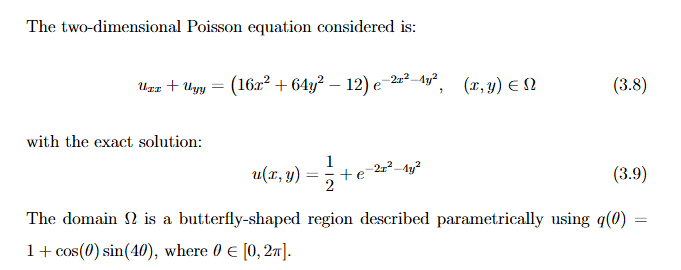

Mean Absolute Error (MAE)     : 4.804464e-03
Root Mean Square Error (RMSE) : 5.726068e-03
CPU Time (Tcpu)               : 1.616797e+00 seconds


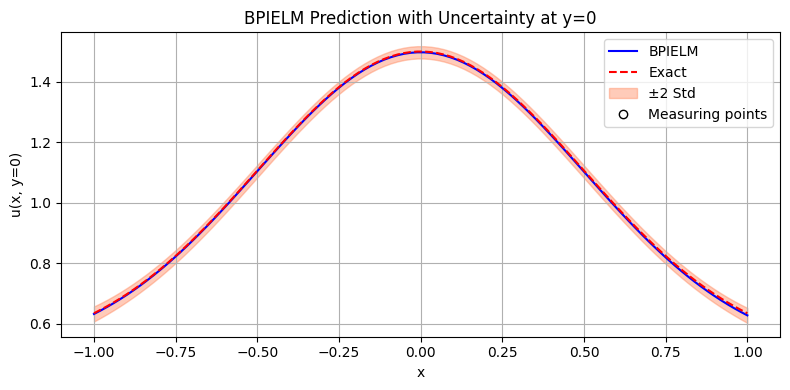

In [ ]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import time

# -------------------------------------------------------------------------
# Activation functions and their derivatives
# -------------------------------------------------------------------------

# Hyperbolic tangent activation function
def activation(z):
    return np.tanh(z)

# First derivative of the tanh function (not used in this implementation)
def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# Second derivative of the tanh function, required for PDE residuals
def activation_second_derivative(z):
    return -2 * np.tanh(z) * (1 - np.tanh(z) ** 2)

# -------------------------------------------------------------------------
# Exact solution and source term for the 2D diffusion PDE
# -------------------------------------------------------------------------

# Exact analytical solution u(x, y) used for boundary condition enforcement and error evaluation
def exact_solution(x, y):
    return 0.5 + np.exp(-2 * x**2 - 4 * y**2)

# Right-hand side (source term) f(x, y) derived from the exact solution
def rhs_function(x, y):
    return (16 * x**2 + 64 * y**2 - 12) * np.exp(-2 * x**2 - 4 * y**2)

# -------------------------------------------------------------------------
# Timer start for measuring CPU time
# -------------------------------------------------------------------------

start_time = time.process_time()

# -------------------------------------------------------------------------
# Generate collocation points for enforcing the PDE inside the domain
# -------------------------------------------------------------------------

N_collocation = 400  # Number of interior (collocation) points
x_collocation = np.random.uniform(-1, 1, (N_collocation, 1))
y_collocation = np.random.uniform(-1, 1, (N_collocation, 1))
XY_collocation = np.hstack([x_collocation, y_collocation])  # Shape: (400, 2)

# -------------------------------------------------------------------------
# Generate boundary points for enforcing Dirichlet boundary conditions
# -------------------------------------------------------------------------

x_boundary = np.linspace(-1, 1, 10)
y_boundary = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_boundary, y_boundary)

# Construct boundary points on each side of the square domain
boundary_left   = np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0]))
boundary_right  = np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1]))
boundary_bottom = np.column_stack((xb[0, :], np.full_like(xb[0, :], -1)))
boundary_top    = np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1)))

# Stack all boundary points into one array
XY_boundary = np.vstack([boundary_left, boundary_right, boundary_bottom, boundary_top])
N_boundary = XY_boundary.shape[0]  # Total number of boundary points

# -------------------------------------------------------------------------
# ELM (Extreme Learning Machine) model parameters
# -------------------------------------------------------------------------

N_neurons = N_collocation + N_boundary  # Number of hidden neurons
d = 2  # Input dimension (x and y)

# Random initialization of weights and biases for the hidden layer
np.random.seed(0)
W = np.random.uniform(-1, 1, (d, N_neurons))   # Shape: (2, N_neurons)
b = np.random.uniform(-1, 1, (1, N_neurons))   # Shape: (1, N_neurons)

# -------------------------------------------------------------------------
# Compute hidden layer outputs for collocation points
# -------------------------------------------------------------------------

Z_col = XY_collocation @ W + b  # Linear transform input for activation
H_col_xx = activation_second_derivative(Z_col) * (W[0, :] ** 2)  # ∂²u/∂x²
H_col_yy = activation_second_derivative(Z_col) * (W[1, :] ** 2)  # ∂²u/∂y²
H_col = H_col_xx + H_col_yy  # Total PDE residual (Laplacian approximation)
R_col = rhs_function(XY_collocation[:, 0], XY_collocation[:, 1]).reshape(-1)  # f(x,y) values

# -------------------------------------------------------------------------
# Compute hidden layer outputs for boundary points
# -------------------------------------------------------------------------

Z_bc = XY_boundary @ W + b
H_bc = activation(Z_bc)  # Output of hidden layer for boundary points
R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1]).reshape(-1)  # Boundary target values

# -------------------------------------------------------------------------
# Stack collocation and boundary data to form the training system
# -------------------------------------------------------------------------

H_total = np.vstack((H_col, H_bc))  # Design matrix
K_total = np.concatenate((R_col, R_bc))  # Target vector

# -------------------------------------------------------------------------
# Bayesian ELM solution
# -------------------------------------------------------------------------

gamma = 1e-6  # Prior regularization parameter
r2 = 1e-4     # Noise variance

I = np.eye(H_total.shape[1])  # Identity matrix of appropriate size
HtH = H_total.T @ H_total     # HᵀH
HtY = H_total.T @ K_total     # HᵀY

# Compute posterior covariance matrix (inverse of precision matrix)
R_mat = np.linalg.inv(gamma * I + (1 / r2) * HtH)

# Compute posterior mean of weights
l = (1 / r2) * R_mat @ HtY

# -------------------------------------------------------------------------
# Generate test grid for evaluation
# -------------------------------------------------------------------------

x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])  # Shape: (10000, 2)

# -------------------------------------------------------------------------
# Make predictions and compute exact solution on test grid
# -------------------------------------------------------------------------

Z_test = XY_test @ W + b
H_test = activation(Z_test)

u_pred = H_test @ l  # Predicted solution
u_exact = exact_solution(XY_test[:, 0], XY_test[:, 1])  # Ground truth

# -------------------------------------------------------------------------
# Compute predictive variance for each test point
# -------------------------------------------------------------------------

var_pred = np.array([
    r2 + (H_test[i, :] @ R_mat @ H_test[i, :].T) for i in range(H_test.shape[0])
])  # Total predictive variance including noise and model uncertainty

# -------------------------------------------------------------------------
# Compute error metrics
# -------------------------------------------------------------------------

error = u_exact - u_pred
abs_error = np.abs(error)
mae = np.mean(abs_error)  # Mean Absolute Error
rmse = np.sqrt(np.mean(error ** 2))  # Root Mean Square Error
end_time = time.process_time()
Tcpu = end_time - start_time  # Total computation time

# Print performance metrics
print(f"Mean Absolute Error (MAE)     : {mae:.6e}")
print(f"Root Mean Square Error (RMSE) : {rmse:.6e}")
print(f"CPU Time (Tcpu)               : {Tcpu:.6e} seconds")

# -------------------------------------------------------------------------
# Reshape predictions and uncertainty for visualization
# -------------------------------------------------------------------------

U_pred = u_pred.reshape(100, 100)      # Predicted solution grid
U_exact = u_exact.reshape(100, 100)    # Exact solution grid
STD = np.sqrt(var_pred).reshape(100, 100)  # Standard deviation (uncertainty)

# -------------------------------------------------------------------------
# Plot the predicted solution with uncertainty band at y = 0
# -------------------------------------------------------------------------

mid_index = 50  # Index corresponding to y = 0 in test grid
x_plot = x_test
u_pred_plot = U_pred[mid_index, :]
u_exact_plot = U_exact[mid_index, :]
std_plot = STD[mid_index, :]

# Select boundary measurement points that lie close to y = 0
mask_y0 = np.abs(XY_boundary[:, 1]) < 0.05
x_meas = XY_boundary[mask_y0, 0]
y_meas = R_bc[mask_y0]

# Plot predicted and exact solutions along with uncertainty and measurements
plt.figure(figsize=(8, 4))
plt.plot(x_plot, u_pred_plot, 'b-', label='BPIELM')
plt.plot(x_plot, u_exact_plot, 'r--', label='Exact')

# Plot ±2 standard deviation uncertainty band
plt.fill_between(x_plot,
                 u_pred_plot - 2 * std_plot,
                 u_pred_plot + 2 * std_plot,
                 color='coral', alpha=0.4, label='±2 Std')

# Plot boundary measurement points
plt.plot(x_meas, y_meas, 'ko', markerfacecolor='none', label='Measuring points')

plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.title("BPIELM Prediction with Uncertainty at y=0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


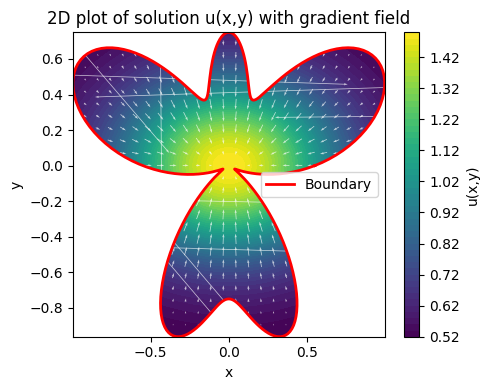

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# ------------------------------------------------------------------------
# Define the exact solution u(x, y) = 0.5 + exp(-2x² - 4y²)
# This will be evaluated only inside the domain
# ------------------------------------------------------------------------
def exact_solution(x, y):
    return 0.5 + np.exp(-2 * x**2 - 4 * y**2)

# ------------------------------------------------------------------------
# Define a parametric boundary curve using q(θ)
# This creates a non-trivial, smooth closed domain
# ------------------------------------------------------------------------
def q(theta):
    return 1 + np.cos(theta) * np.sin(4 * theta)

# Generate boundary points using the parametric equation
theta = np.linspace(0, 2 * np.pi, 300)
x_boundary = 0.55 * q(theta) * np.cos(theta)
y_boundary = 0.75 * q(theta) * np.sin(theta)

# Create a Path object from boundary points for point-in-domain testing
boundary_path = Path(np.vstack((x_boundary, y_boundary)).T)

# ------------------------------------------------------------------------
# Define a uniform grid over a rectangular box enclosing the domain
# ------------------------------------------------------------------------
x_min, x_max = x_boundary.min(), x_boundary.max()
y_min, y_max = y_boundary.min(), y_boundary.max()
nx, ny = 200, 200  # Grid resolution

x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x, y)  # Shape: (ny, nx)

# ------------------------------------------------------------------------
# Check which grid points lie inside the parametric domain
# ------------------------------------------------------------------------
points = np.vstack((X.ravel(), Y.ravel())).T  # Shape: (nx*ny, 2)
inside = boundary_path.contains_points(points)  # Boolean mask

# ------------------------------------------------------------------------
# Evaluate exact solution at interior points; outside points set to NaN
# ------------------------------------------------------------------------
U = np.full(points.shape[0], np.nan)  # Initialize all values as NaN
U[inside] = exact_solution(points[inside, 0], points[inside, 1])  # Evaluate u

# Reshape solution array back to 2D grid shape
U_grid = U.reshape(X.shape)

# ------------------------------------------------------------------------
# Compute numerical gradients of u(x,y) using central differences
# ------------------------------------------------------------------------

dx = x[1] - x[0]
dy = y[1] - y[0]

# Temporarily fill NaNs with 0 for stable gradient computation
U_filled = np.nan_to_num(U_grid, nan=0.0)

# Compute gradients with respect to y and x
Uy, Ux = np.gradient(U_filled, dy, dx)  # Uy: ∂u/∂y, Ux: ∂u/∂x

# Mask gradients outside the domain by setting them to 0
Ux[np.isnan(U_grid)] = 0
Uy[np.isnan(U_grid)] = 0

# ------------------------------------------------------------------------
# Visualization: Contour plot of u(x,y) with vector field (gradient)
# ------------------------------------------------------------------------

plt.figure(figsize=(5, 4))

# Filled contour plot of the solution
contour = plt.contourf(X, Y, U_grid, 50, cmap='viridis')
plt.colorbar(contour, label='u(x,y)')


# Quiver plot of the gradient field (sampled sparsely for clarity)
skip = (slice(None, None, 8), slice(None, None, 8))  # Sample every 8th point
plt.quiver(X[skip], Y[skip], Ux[skip], Uy[skip], color='white', pivot='mid', alpha=0.7)

# Plot the boundary of the domain
plt.plot(x_boundary, y_boundary, 'r-', linewidth=2, label='Boundary')

# Plot settings
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D plot of solution u(x,y) with gradient field')
plt.legend()

plt.tight_layout()
plt.show()


Applying Ridge Regression

Best Lambda: 1.00e-08
Mean Absolute Error (MAE): 6.731859e-04
Root Mean Square Error (RMSE): 1.142675e-03
CPU Time (Tcpu): 1.528648 seconds


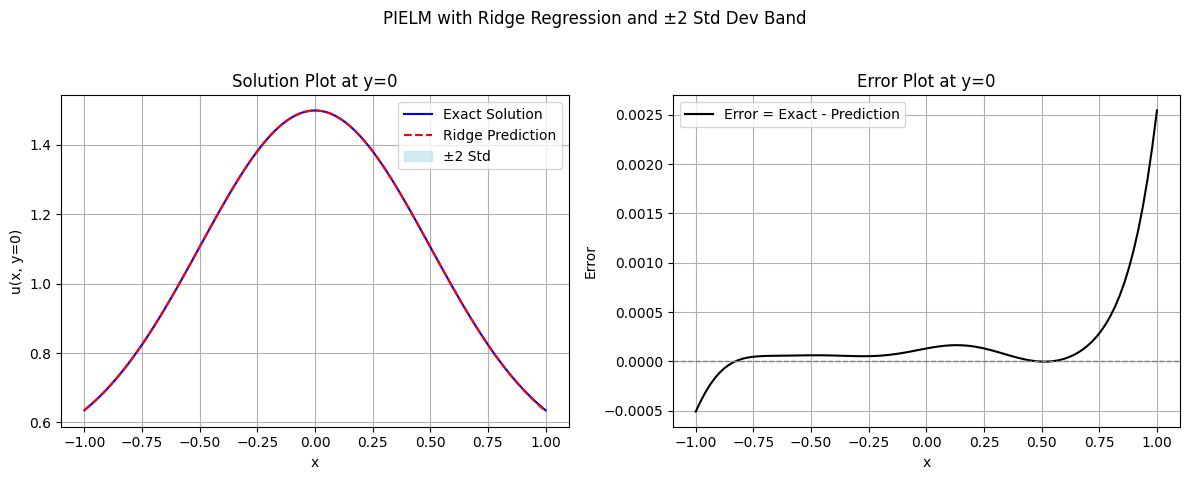

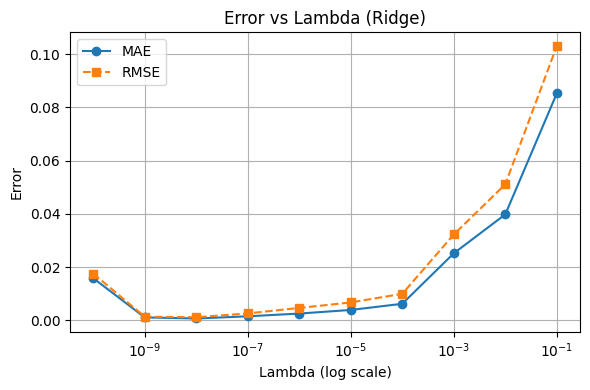

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# -----------------------------
# Activation Functions
# -----------------------------

# Nonlinear activation function (tanh)
def activation(z):
    return np.tanh(z)

# First derivative (not used here)
def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# Second derivative used to approximate Laplacian
def activation_second_derivative(z):
    return -2 * np.tanh(z) * (1 - np.tanh(z) ** 2)

# -----------------------------
# PDE Exact Solution and RHS
# -----------------------------

# Exact solution u(x, y) for evaluation and boundary condition enforcement
def exact_solution(x, y):
    return 0.5 + np.exp(-2 * x**2 - 4 * y**2)

# Corresponding right-hand side f(x, y) = ∇²u(x, y)
def rhs_function(x, y):
    return (16 * x**2 + 64 * y**2 - 12) * np.exp(-2 * x**2 - 4 * y**2)

# -----------------------------
# Begin timer
# -----------------------------
start_time = time.process_time()

# -----------------------------
# Generate Collocation Points (interior)
# -----------------------------
N_collocation = 400
x_col = np.random.uniform(-1, 1, (N_collocation, 1))
y_col = np.random.uniform(-1, 1, (N_collocation, 1))
XY_col = np.hstack([x_col, y_col])

# -----------------------------
# Generate Boundary Points (Dirichlet BCs)
# -----------------------------
x_boundary = np.linspace(-1, 1, 10)
y_boundary = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_boundary, y_boundary)

boundary_left   = np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0]))
boundary_right  = np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1]))
boundary_bottom = np.column_stack((xb[0, :], np.full_like(xb[0, :], -1)))
boundary_top    = np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1)))
XY_boundary = np.vstack([boundary_left, boundary_right, boundary_bottom, boundary_top])

# -----------------------------
# Initialize ELM weights and biases
# -----------------------------
N_neurons = N_collocation + XY_boundary.shape[0]
d = 2  # input dimensions (x, y)

np.random.seed(0)
W = np.random.uniform(-1, 1, (d, N_neurons))    # Weight matrix: (2, N_neurons)
b = np.random.uniform(-1, 1, (1, N_neurons))    # Bias vector: (1, N_neurons)

# -----------------------------
# Hidden layer output at collocation points (for PDE residual)
# -----------------------------
Z_col = XY_col @ W + b
H_col_xx = activation_second_derivative(Z_col) * (W[0, :] ** 2)
H_col_yy = activation_second_derivative(Z_col) * (W[1, :] ** 2)
H_col = H_col_xx + H_col_yy  # ∇²u approximation
R_col = rhs_function(XY_col[:, 0], XY_col[:, 1]).reshape(-1)

# -----------------------------
# Hidden layer output at boundary points
# -----------------------------
Z_bc = XY_boundary @ W + b
H_bc = activation(Z_bc)
R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1]).reshape(-1)

# -----------------------------
# Combine collocation and boundary equations
# -----------------------------
H_total = np.vstack((H_col, H_bc))  # Design matrix
K_total = np.concatenate((R_col, R_bc))  # Target vector

# -----------------------------
# Generate test grid
# -----------------------------
x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])

# Compute exact solution on test grid
u_exact = exact_solution(XY_test[:, 0], XY_test[:, 1])

# Hidden layer output on test points
Z_test = XY_test @ W + b
H_test = activation(Z_test)

# -----------------------------
# Ridge Regression loop for hyperparameter tuning (λ)
# -----------------------------
lambdas = np.logspace(-10, -1, 10)
mae_list = []
rmse_list = []
C_list = []

for lam in lambdas:
    I = np.eye(H_total.shape[1])  # Identity matrix
    # Solve regularized least squares: C = (HᵗH + λI)⁻¹ HᵗK
    C_ridge = np.linalg.inv(H_total.T @ H_total + lam * I) @ (H_total.T @ K_total)
    C_list.append(C_ridge)

    # Predict solution on test data
    u_pred = H_test @ C_ridge
    abs_error = np.abs(u_exact - u_pred)
    mae = np.mean(abs_error)
    rmse = np.sqrt(np.mean((u_exact - u_pred) ** 2))
    mae_list.append(mae)
    rmse_list.append(rmse)

# -----------------------------
# Choose best model (based on MAE)
# -----------------------------
best_index = np.argmin(mae_list)
best_lambda = lambdas[best_index]
best_C = C_list[best_index]

# Final prediction using best λ
u_pred = H_test @ best_C
error = u_exact - u_pred

# -----------------------------
# Estimate predictive variance (posterior variance)
# -----------------------------
I = np.eye(H_total.shape[1])
A_inv = np.linalg.inv(H_total.T @ H_total + best_lambda * I)
sigma2 = np.mean(error**2)  # empirical noise variance
var_pred = np.sum(H_test @ A_inv * H_test, axis=1) * sigma2
std_pred = np.sqrt(var_pred).reshape(100, 100)  # reshape to 2D grid

# -----------------------------
# Final metrics and reshaping
# -----------------------------
end_time = time.process_time()
Tcpu = end_time - start_time

print(f"Best Lambda: {best_lambda:.2e}")
print(f"Mean Absolute Error (MAE): {mae_list[best_index]:.6e}")
print(f"Root Mean Square Error (RMSE): {rmse_list[best_index]:.6e}")
print(f"CPU Time (Tcpu): {Tcpu:.6f} seconds")

U_pred = u_pred.reshape(100, 100)
U_exact = u_exact.reshape(100, 100)
error_grid = error.reshape(100, 100)

# Extract cross-section at y = 0
idx_mid = 50
x_plot = x_test
u_pred_plot = U_pred[idx_mid, :]
u_exact_plot = U_exact[idx_mid, :]
std_plot = std_pred[idx_mid, :]
err_plot = error_grid[idx_mid, :]

# -----------------------------
# Plot predicted solution with uncertainty band
# -----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_plot, u_exact_plot, 'b-', label='Exact Solution')
plt.plot(x_plot, u_pred_plot, 'r--', label='Ridge Prediction')
plt.fill_between(x_plot,
                 u_pred_plot - 2 * std_plot,
                 u_pred_plot + 2 * std_plot,
                 color='lightblue', alpha=0.5, label='±2 Std')
plt.title('Solution Plot at y=0')
plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.legend()
plt.grid(True)

# -----------------------------
# Plot error curve at y = 0
# -----------------------------
plt.subplot(1, 2, 2)
plt.plot(x_plot, err_plot, 'k-', label='Error = Exact - Prediction')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Error Plot at y=0')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.suptitle('PIELM with Ridge Regression and ±2 Std Dev Band')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -----------------------------
# Plot Error vs Lambda
# -----------------------------
plt.figure(figsize=(6, 4))
plt.semilogx(lambdas, mae_list, 'o-', label='MAE')
plt.semilogx(lambdas, rmse_list, 's--', label='RMSE')
plt.title('Error vs Lambda (Ridge)')
plt.xlabel('Lambda (log scale)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best Neuron count


Best Neuron Count: 175
MAE: 1.591316e-05
RMSE: 3.496201e-05
CPU Time: 41.575 s


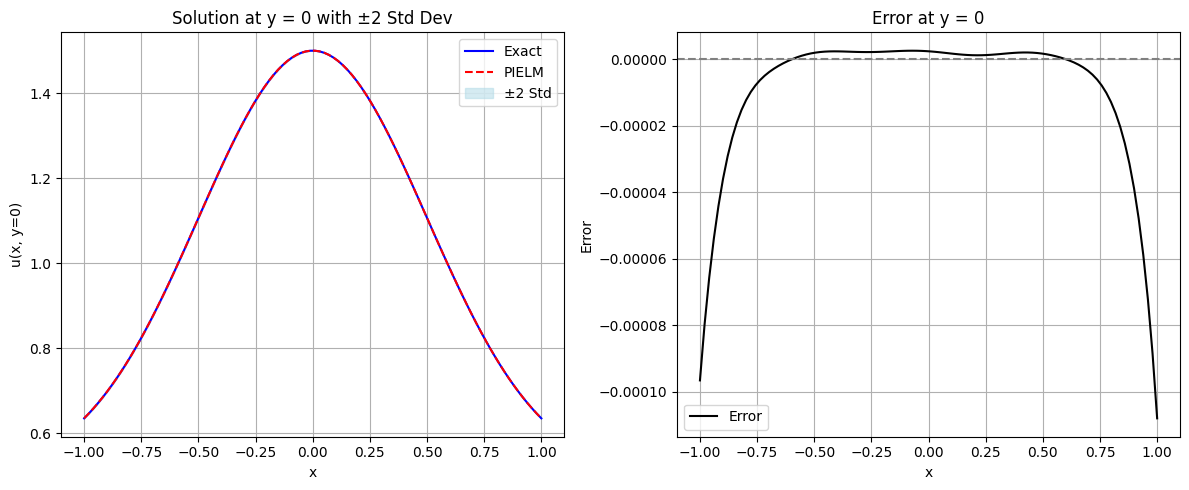

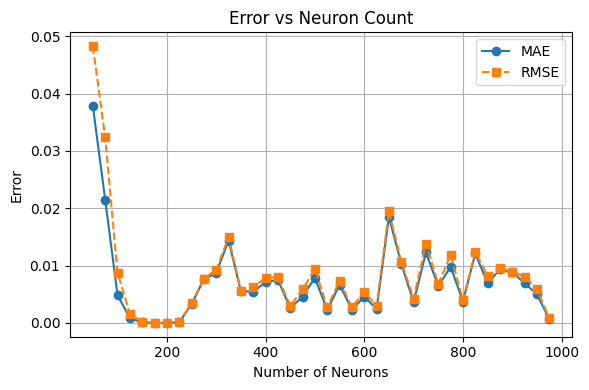

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# -------------------------
# Activation Function Setup
# -------------------------

# Activation function: tanh
def activation(z):
    return np.tanh(z)

# First derivative of tanh
def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# Second derivative of tanh used to approximate the Laplacian
def activation_second_derivative(z):
    return -2 * np.tanh(z) * (1 - np.tanh(z) ** 2)

# -------------------------
# PDE Problem Specification
# -------------------------

# Known exact solution of the PDE used for boundary values and evaluation
def exact_solution(x, y):
    return 0.5 + np.exp(-2 * x**2 - 4 * y**2)

# Corresponding source term (RHS of the PDE), computed analytically
def rhs_function(x, y):
    return (16 * x**2 + 64 * y**2 - 12) * np.exp(-2 * x**2 - 4 * y**2)

# -------------------------
# Data Preparation
# -------------------------

# Generate collocation points inside domain for enforcing PDE
N_collocation = 400
x_col = np.random.uniform(-1, 1, (N_collocation, 1))
y_col = np.random.uniform(-1, 1, (N_collocation, 1))
XY_col = np.hstack([x_col, y_col])  # Shape: (400, 2)

# Generate boundary points (structured on the square [-1,1]^2)
x_boundary = np.linspace(-1, 1, 10)
y_boundary = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_boundary, y_boundary)

# Combine boundary segments: left, right, bottom, top
boundary_left   = np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0]))
boundary_right  = np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1]))
boundary_bottom = np.column_stack((xb[0, :], np.full_like(xb[0, :], -1)))
boundary_top    = np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1)))
XY_boundary = np.vstack([boundary_left, boundary_right, boundary_bottom, boundary_top])  # (360, 2)

# Create test grid for evaluation (100x100 points over domain)
x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])  # (10000, 2)
u_exact_test = exact_solution(XY_test[:, 0], XY_test[:, 1])

# -------------------------
# Neural Network Sweep Setup
# -------------------------

# Range of hidden neuron counts to evaluate model performance
neuron_range = range(50, 1000, 25)

# Storage lists for each model's results
mae_list = []
rmse_list = []
C_list = []
W_list = []
b_list = []
neuron_list = []

# Record training time
start_time = time.process_time()

# -------------------------
# Loop over hidden neuron counts
# -------------------------

for N_neurons in neuron_range:
    # Fix seed for reproducibility of weights and biases
    np.random.seed(0)
    d = 2  # Input dimension: x and y

    # Random initialization of input weights and biases
    W = np.random.uniform(-1, 1, (d, N_neurons))   # Shape: (2, N_neurons)
    b = np.random.uniform(-1, 1, (1, N_neurons))   # Shape: (1, N_neurons)

    # Construct hidden layer matrix for PDE collocation loss (Laplacian)
    Z_col = XY_col @ W + b  # Shape: (400, N_neurons)
    H_col_xx = activation_second_derivative(Z_col) * (W[0, :] ** 2)
    H_col_yy = activation_second_derivative(Z_col) * (W[1, :] ** 2)
    H_col = H_col_xx + H_col_yy  # ∇²u approximation
    R_col = rhs_function(XY_col[:, 0], XY_col[:, 1]).reshape(-1)  # True PDE values

    # Construct hidden layer matrix for boundary condition loss
    Z_bc = XY_boundary @ W + b  # Shape: (360, N_neurons)
    H_bc = activation(Z_bc)
    R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1]).reshape(-1)

    # Stack PDE and boundary constraints
    H_total = np.vstack((H_col, H_bc))  # Shape: (760, N_neurons)
    K_total = np.concatenate((R_col, R_bc))  # Shape: (760,)

    # Solve for output weights using pseudo-inverse (least squares solution)
    C = np.linalg.pinv(H_total) @ K_total

    # Store model parameters
    C_list.append(C)
    W_list.append(W)
    b_list.append(b)
    neuron_list.append(N_neurons)

    # Evaluate on test grid
    Z_test = XY_test @ W + b
    H_test = activation(Z_test)
    u_pred = H_test @ C

    # Compute prediction errors
    error = u_exact_test - u_pred
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error ** 2))

    # Store error metrics
    mae_list.append(mae)
    rmse_list.append(rmse)

# -------------------------
# Select Best Model (lowest MAE)
# -------------------------

best_index = np.argmin(mae_list)
best_N = neuron_list[best_index]
best_C = C_list[best_index]
best_W = W_list[best_index]
best_b = b_list[best_index]

# Recompute final predictions using best model
Z_test = XY_test @ best_W + best_b
H_test = activation(Z_test)
u_best_pred = H_test @ best_C
error = u_exact_test - u_best_pred
sigma2 = np.mean(error ** 2)  # Estimated noise variance from residuals

# -------------------------
# Estimate Predictive Variance (Pseudo Bayesian Uncertainty)
# -------------------------

# Rebuild total design matrix for the best model
H_total_best = np.vstack([
    activation_second_derivative(XY_col @ best_W + best_b) * (best_W[0, :] ** 2) +
    activation_second_derivative(XY_col @ best_W + best_b) * (best_W[1, :] ** 2),
    activation(XY_boundary @ best_W + best_b)
])

# Inverse of Gram matrix (for variance estimation)
HtH_inv = np.linalg.pinv(H_total_best.T @ H_total_best)

# Predictive variance for each test point: diag(H A⁻¹ Hᵗ) * σ²
var_pred = np.sum(H_test @ HtH_inv * H_test, axis=1) * sigma2
std_pred = np.sqrt(var_pred).reshape(100, 100)

# -------------------------
# Report Final Results
# -------------------------

end_time = time.process_time()
tcpu = end_time - start_time

print(f"Best Neuron Count: {best_N}")
print(f"MAE: {mae_list[best_index]:.6e}")
print(f"RMSE: {rmse_list[best_index]:.6e}")
print(f"CPU Time: {tcpu:.3f} s")

# -------------------------
# Plot Results at y = 0
# -------------------------

U_pred = u_best_pred.reshape(100, 100)
U_exact = u_exact_test.reshape(100, 100)
error_grid = error.reshape(100, 100)

idx_mid = 50  # Middle slice: y ≈ 0
x_plot = x_test
u_pred_plot = U_pred[idx_mid, :]
u_exact_plot = U_exact[idx_mid, :]
std_plot = std_pred[idx_mid, :]
err_plot = error_grid[idx_mid, :]

# Plot predicted solution with ±2 standard deviation band
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_plot, u_exact_plot, 'b-', label='Exact')
plt.plot(x_plot, u_pred_plot, 'r--', label='PIELM')
plt.fill_between(x_plot,
                 u_pred_plot - 2 * std_plot,
                 u_pred_plot + 2 * std_plot,
                 color='lightblue', alpha=0.5, label='±2 Std')
plt.title('Solution at y = 0 with ±2 Std Dev')
plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.legend()
plt.grid(True)

# Plot prediction error at y = 0
plt.subplot(1, 2, 2)
plt.plot(x_plot, err_plot, 'k-', label='Error')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Error at y = 0')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# Plot Error vs Neuron Count
# -------------------------

plt.figure(figsize=(6, 4))
plt.plot(neuron_list, mae_list, 'o-', label='MAE')
plt.plot(neuron_list, rmse_list, 's--', label='RMSE')
plt.xlabel('Number of Neurons')
plt.ylabel('Error')
plt.title('Error vs Neuron Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Applying ridge regression + best neuron count


Best Number of Neurons: 975
Best Lambda: 1.00e-10
Mean Absolute Error (MAE): 3.545034e-05
Root Mean Square Error (RMSE): 6.744117e-05
CPU Time (Tcpu): 2.799179e+02 seconds


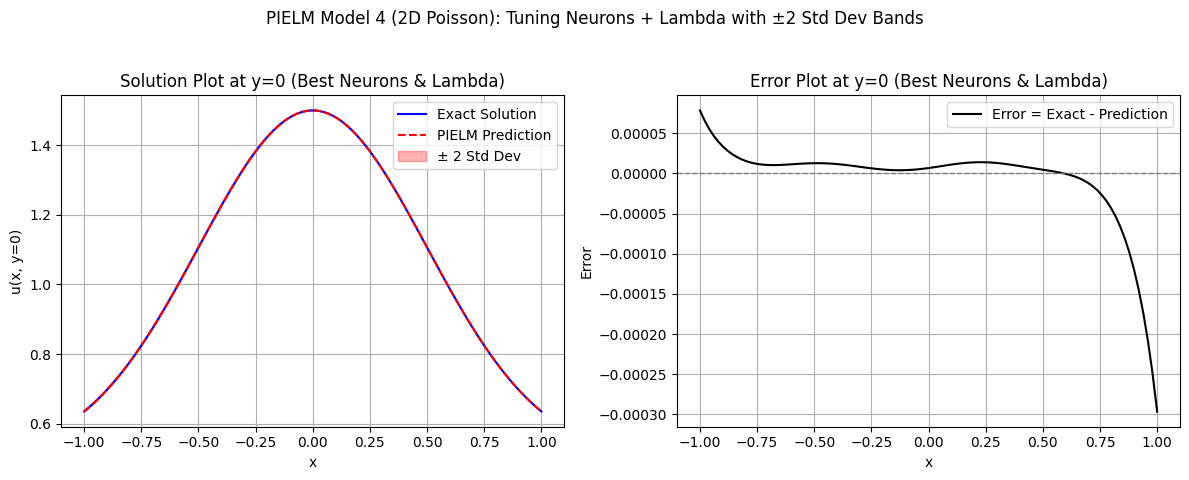

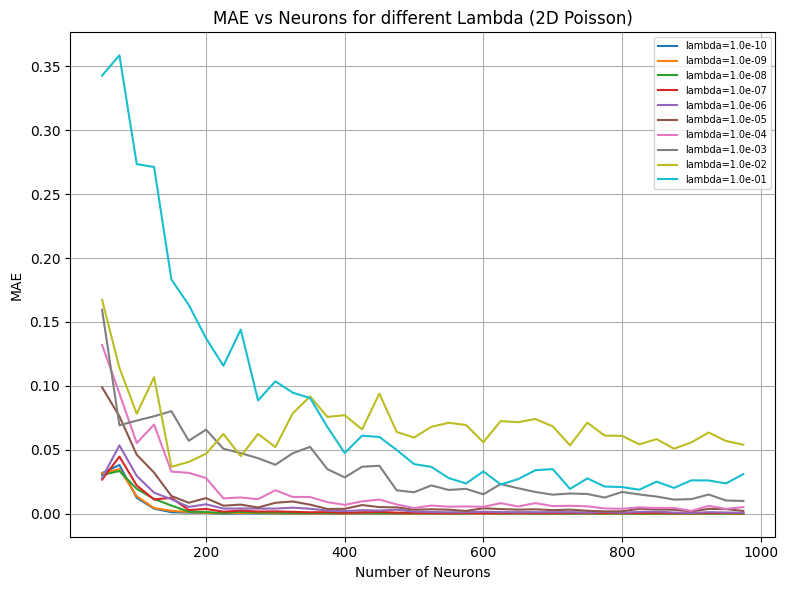

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# ----------------------------
# Activation and Helper Functions
# ----------------------------

# tanh activation function for hidden neurons
def activation(z):
    return np.tanh(z)

# Second derivative of tanh used in computing Laplacian (PDE residual)
def activation_second_derivative(z):
    return -2 * np.tanh(z) * (1 - np.tanh(z) ** 2)

# Analytical exact solution of the 2D Poisson equation
def exact_solution(x, y):
    return 0.5 + np.exp(-2 * x**2 - 4 * y**2)

# Right-hand side (forcing function) of the Poisson PDE
def rhs_function(x, y):
    return (16 * x**2 + 64 * y**2 - 12) * np.exp(-2 * x**2 - 4 * y**2)

# ----------------------------
# Start Timer
# ----------------------------
start_time = time.process_time()

# ----------------------------
# Collocation and Boundary Points
# ----------------------------

# Generate interior collocation points uniformly in [-1,1]^2
N_collocation = 400
x_col = np.random.uniform(-1, 1, (N_collocation, 1))
y_col = np.random.uniform(-1, 1, (N_collocation, 1))
XY_col = np.hstack([x_col, y_col])  # Shape: (400, 2)

# Generate boundary points (structured grid on boundary of [-1,1]^2)
x_boundary = np.linspace(-1, 1, 10)
y_boundary = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_boundary, y_boundary)

# Stack all four boundary edges into a single array
boundary_left   = np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0]))
boundary_right  = np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1]))
boundary_bottom = np.column_stack((xb[0, :], np.full_like(xb[0, :], -1)))
boundary_top    = np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1)))
XY_boundary = np.vstack([boundary_left, boundary_right, boundary_bottom, boundary_top])  # Shape: (360, 2)

# ----------------------------
# Create Test Grid for Evaluation
# ----------------------------

x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])  # Shape: (10000, 2)

# Exact solution at test points (used for error evaluation)
u_exact = exact_solution(XY_test[:, 0], XY_test[:, 1])

# ----------------------------
# Define Hyperparameter Ranges
# ----------------------------

d = 2  # Input dimension (x, y)
neuron_range = range(50, 1000, 25)  # Number of neurons to test
lambdas = np.logspace(-10, -1, 10)  # Regularization strengths for ridge regression
results = []  # Store results for all (neurons, lambda) combinations

# ----------------------------
# Loop Over Neuron Counts
# ----------------------------

for N_neurons in neuron_range:
    np.random.seed(0)  # Fix seed for reproducibility

    # Random initialization of input weights W and biases b
    W = np.random.uniform(-1, 1, (d, N_neurons))  # Shape: (2, N_neurons)
    b = np.random.uniform(-1, 1, (1, N_neurons))  # Shape: (1, N_neurons)

    # --- Compute design matrix H for PDE residuals ---

    Z_col = XY_col @ W + b
    H_col_xx = activation_second_derivative(Z_col) * (W[0, :] ** 2)  # ∂²u/∂x²
    H_col_yy = activation_second_derivative(Z_col) * (W[1, :] ** 2)  # ∂²u/∂y²
    H_col = H_col_xx + H_col_yy  # Laplacian approximation
    R_col = rhs_function(XY_col[:, 0], XY_col[:, 1]).reshape(-1)  # Target values

    # --- Compute design matrix H for boundary conditions ---

    Z_bc = XY_boundary @ W + b
    H_bc = activation(Z_bc)
    R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1]).reshape(-1)  # Exact boundary values

    # Combine PDE and boundary losses
    H_total = np.vstack((H_col, H_bc))       # Combined design matrix
    K_total = np.concatenate((R_col, R_bc))  # Combined target vector

    # ----------------------------
    # Ridge Regression for each lambda
    # ----------------------------

    for lam in lambdas:
        I = np.eye(H_total.shape[1])
        HtH_lam = H_total.T @ H_total + lam * I  # Regularized Gram matrix
        C_ridge = np.linalg.solve(HtH_lam, H_total.T @ K_total)  # Solve ridge regression

        # Predict at test points
        Z_test = XY_test @ W + b
        H_test = activation(Z_test)
        u_pred = H_test @ C_ridge

        # Compute errors
        abs_error = np.abs(u_exact - u_pred)
        mae = np.mean(abs_error)
        rmse = np.sqrt(np.mean((u_exact - u_pred) ** 2))

        # Store all relevant results
        results.append({
            'neurons': N_neurons,
            'lambda': lam,
            'mae': mae,
            'rmse': rmse,
            'C': C_ridge,
            'W': W,
            'b': b,
            'HtH_lam': HtH_lam,
            'H_total': H_total
        })

# ----------------------------
# Select Best Model by MAE
# ----------------------------

best_result = min(results, key=lambda x: x['mae'])
best_N = best_result['neurons']
best_lambda = best_result['lambda']
best_C = best_result['C']
W = best_result['W']
b = best_result['b']
HtH_lam = best_result['HtH_lam']
H_total = best_result['H_total']

# ----------------------------
# Final Prediction and Error Estimation
# ----------------------------

Z_test = XY_test @ W + b
H_test = activation(Z_test)
u_pred = H_test @ best_C
error = u_exact - u_pred

# Estimate residual-based noise variance σ² using training residuals
residuals = H_total @ best_C - np.concatenate((
    rhs_function(XY_col[:, 0], XY_col[:, 1]),
    exact_solution(XY_boundary[:, 0], XY_boundary[:, 1])
))
sigma2 = np.mean(residuals**2)

# Estimate predictive variance: σ² * diag(H_test @ inv(HᵗH + λI) @ H_testᵗ)
HtH_lam_inv = np.linalg.inv(HtH_lam)
var_pred = sigma2 * np.sum(H_test @ HtH_lam_inv * H_test, axis=1)
std_pred = np.sqrt(var_pred).reshape(100, 100)  # Reshape to grid

# ----------------------------
# Visualization Prep (y=0 slice)
# ----------------------------

idx_y0 = 50  # Mid-line in y (i.e., y=0)
x_plot = x_test
u_pred_y0 = u_pred.reshape(100, 100)[idx_y0, :]
u_exact_y0 = u_exact.reshape(100, 100)[idx_y0, :]
std_y0 = std_pred[idx_y0, :]
err_y0 = error.reshape(100, 100)[idx_y0, :]

# ----------------------------
# Print Summary
# ----------------------------

end_time = time.process_time()
Tcpu = end_time - start_time

print(f"Best Number of Neurons: {best_N}")
print(f"Best Lambda: {best_lambda:.2e}")
print(f"Mean Absolute Error (MAE): {best_result['mae']:.6e}")
print(f"Root Mean Square Error (RMSE): {best_result['rmse']:.6e}")
print(f"CPU Time (Tcpu): {Tcpu:.6e} seconds")

# ----------------------------
# Plot Prediction with ±2 Std Dev
# ----------------------------

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_plot, u_exact_y0, 'b-', label='Exact Solution')
plt.plot(x_plot, u_pred_y0, 'r--', label='PIELM Prediction')
plt.fill_between(x_plot,
                 u_pred_y0 - 2 * std_y0,
                 u_pred_y0 + 2 * std_y0,
                 color='r', alpha=0.3, label='± 2 Std Dev')
plt.title('Solution Plot at y=0 (Best Neurons & Lambda)')
plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_plot, err_y0, 'k-', label='Error = Exact - Prediction')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Error Plot at y=0 (Best Neurons & Lambda)')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.suptitle('PIELM Model 4 (2D Poisson): Tuning Neurons + Lambda with ±2 Std Dev Bands')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ----------------------------
# Plot MAE vs Neuron Count for each Lambda
# ----------------------------

df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
for lam in lambdas:
    subset = df[df['lambda'] == lam]
    plt.plot(subset['neurons'], subset['mae'], label=f'lambda={lam:.1e}')
plt.title('MAE vs Neurons for different Lambda (2D Poisson)')
plt.xlabel('Number of Neurons')
plt.ylabel('MAE')
plt.legend(fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()


# Advection Equation

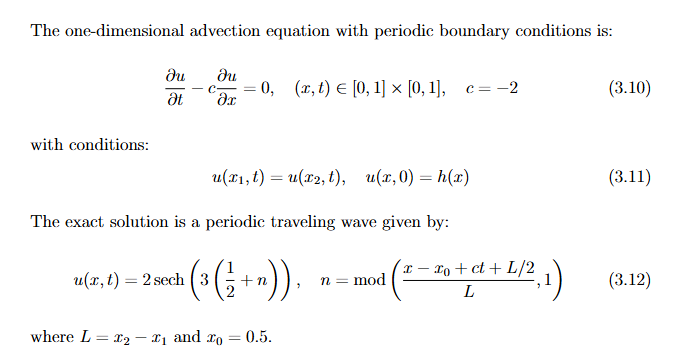

Mean Absolute Error (MAE)       : 1.067236e-04
Root Mean Square Error (RMSE) : 1.378192e-04
CPU Time (Tcpu)                 : 2.940964e+00 seconds


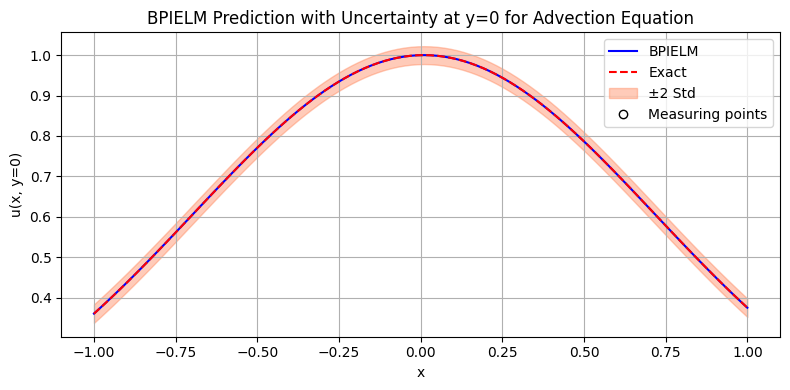

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# -----------------------------
# Activation function and derivatives
# -----------------------------

def activation(z):
    # Hyperbolic tangent activation function
    return np.tanh(z)

def activation_derivative(z):
    # Derivative of tanh used for computing PDE terms
    return 1 - np.tanh(z) ** 2

# -----------------------------
# Exact and RHS for Advection Equation
# -----------------------------

# Known exact solution used for boundary supervision and evaluation
def exact_solution(x, y):
    return np.exp(-(x - y)**2)

# For the advection equation ∂u/∂x + ∂u/∂y = 0, RHS is zero everywhere
def rhs_function(x, y):
    return np.zeros_like(x)

# -----------------------------
# Start Timer
# -----------------------------
start_time = time.process_time()

# -----------------------------
# Generate Collocation Points (Interior)
# -----------------------------

N_collocation = 400
x_collocation = np.random.uniform(-1, 1, (N_collocation, 1))
y_collocation = np.random.uniform(-1, 1, (N_collocation, 1))
XY_collocation = np.hstack([x_collocation, y_collocation])  # Shape: (400, 2)

# -----------------------------
# Generate Boundary Points (Edges of domain)
# -----------------------------

x_boundary = np.linspace(-1, 1, 10)
y_boundary = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_boundary, y_boundary)

# Create boundary arrays from edges of the grid
boundary_left   = np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0]))
boundary_right  = np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1]))
boundary_bottom = np.column_stack((xb[0, :], np.full_like(xb[0, :], -1)))
boundary_top    = np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1)))

# Combine all boundary points
XY_boundary = np.vstack([boundary_left, boundary_right, boundary_bottom, boundary_top])
N_boundary = XY_boundary.shape[0]

# -----------------------------
# ELM Hidden Layer Setup
# -----------------------------

N_neurons = N_collocation + N_boundary  # Total neurons = total data points
d = 2  # Input dimension (x, y)

# Randomly initialize input weights and biases
np.random.seed(0)
W = np.random.uniform(-1, 1, (d, N_neurons))      # Shape: (2, N_neurons)
b = np.random.uniform(-1, 1, (1, N_neurons))      # Shape: (1, N_neurons)

# -----------------------------
# Construct PDE Residual H for Collocation Points
# -----------------------------

Z_col = XY_collocation @ W + b  # Shape: (N_collocation, N_neurons)

# Compute first derivatives using chain rule
H_col_x = activation_derivative(Z_col) * W[0, :]  # ∂u_pred/∂x
H_col_y = activation_derivative(Z_col) * W[1, :]  # ∂u_pred/∂y
H_col = H_col_x + H_col_y                         # Approximates ∂u/∂x + ∂u/∂y

R_col = rhs_function(XY_collocation[:, 0], XY_collocation[:, 1]).reshape(-1)  # RHS = 0

# -----------------------------
# Construct Boundary Supervision H
# -----------------------------

Z_bc = XY_boundary @ W + b
H_bc = activation(Z_bc)  # Feedforward output at boundary locations
R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1]).reshape(-1)

# -----------------------------
# Combine PDE Residual and Boundary Supervision
# -----------------------------

H_total = np.vstack((H_col, H_bc))       # Shape: (N_collocation + N_boundary, N_neurons)
K_total = np.concatenate((R_col, R_bc))  # Target values: zeros for PDE, exact for BC

# -----------------------------
# Bayesian ELM Inference
# -----------------------------

gamma = 1e-6   # Prior precision (weight regularization)
r2 = 1e-4      # Noise variance (likelihood precision)

I = np.eye(H_total.shape[1])             # Identity matrix (N_neurons x N_neurons)
HtH = H_total.T @ H_total                # HᵗH matrix
HtY = H_total.T @ K_total                # Hᵗy vector

# Posterior covariance of weights
R_mat = np.linalg.inv(gamma * I + (1 / r2) * HtH)

# Posterior mean (closed-form Bayesian ridge solution)
l = (1 / r2) * R_mat @ HtY

# -----------------------------
# Prepare Test Grid for Evaluation
# -----------------------------

x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])

# Forward pass through trained ELM
Z_test = XY_test @ W + b
H_test = activation(Z_test)
u_pred = H_test @ l

# Compute exact solution for comparison
u_exact = exact_solution(XY_test[:, 0], XY_test[:, 1])

# -----------------------------
# Bayesian Predictive Variance Estimation
# -----------------------------

# Predictive variance: diag(r² + hᵢᵗ R hᵢ) for each test point
var_pred = np.array([
    r2 + (H_test[i, :] @ R_mat @ H_test[i, :].T) for i in range(H_test.shape[0])
])

# -----------------------------
# Error Metrics
# -----------------------------

error = u_exact - u_pred
abs_error = np.abs(error)
mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(error ** 2))
end_time = time.process_time()
Tcpu = end_time - start_time

# Print performance metrics
print(f"Mean Absolute Error (MAE)       : {mae:.6e}")
print(f"Root Mean Square Error (RMSE) : {rmse:.6e}")
print(f"CPU Time (Tcpu)                 : {Tcpu:.6e} seconds")

# -----------------------------
# Visualization: u(x, y=0) Slice
# -----------------------------

U_pred = u_pred.reshape(100, 100)
U_exact = u_exact.reshape(100, 100)
STD = np.sqrt(var_pred).reshape(100, 100)

# y = 0 line corresponds to index 50 in meshgrid
mid_index = 50
x_plot = x_test
u_pred_plot = U_pred[mid_index, :]
u_exact_plot = U_exact[mid_index, :]
std_plot = STD[mid_index, :]

# Get actual measurement points along y ≈ 0 (for plotting sensors)
mask_y0 = np.abs(XY_boundary[:, 1]) < 0.05
x_meas = XY_boundary[mask_y0, 0]
y_meas = R_bc[mask_y0]

# -----------------------------
# Plot Predictions with ±2 Std Dev Band
# -----------------------------

plt.figure(figsize=(8, 4))
plt.plot(x_plot, u_pred_plot, 'b-', label='BPIELM')
plt.plot(x_plot, u_exact_plot, 'r--', label='Exact')

# Shaded area for ±2 standard deviation
plt.fill_between(x_plot,
                 u_pred_plot - 2 * std_plot,
                 u_pred_plot + 2 * std_plot,
                 color='coral', alpha=0.4, label='±2 Std')

# Plot boundary sensors used at y=0
plt.plot(x_meas, y_meas, 'ko', markerfacecolor='none', label='Measuring points')

plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.title("BPIELM Prediction with Uncertainty at y=0 for Advection Equation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


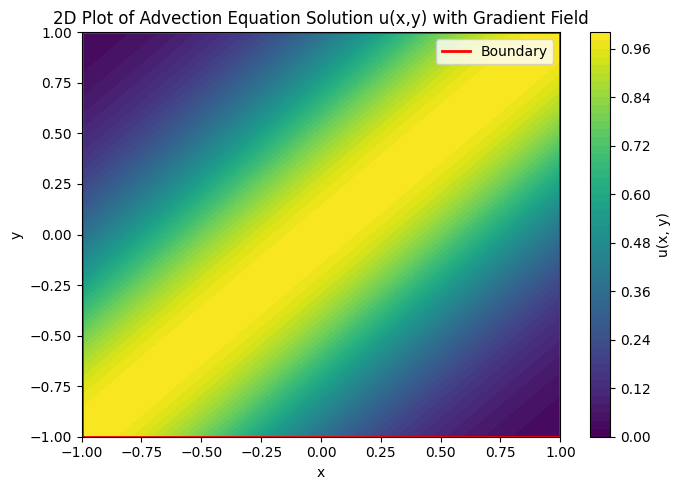

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path  # For domain boundary

# ===========================================
# Exact solution for 2D advection equation
# ===========================================

def exact_solution(x, y):
    """
    Returns the exact solution u(x, y) = exp(-(x - y)^2)
    This satisfies the steady-state 2D advection equation:
        ∂u/∂x + ∂u/∂y = 0
    since d/dx + d/dy of f(x - y) = 0 for any smooth f.
    """
    return np.exp(-(x - y)**2)

# ===========================================
# Define domain bounds and resolution
# ===========================================

# Set domain for a rectangular region: [-1, 1] x [-1, 1]
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Define resolution of the grid
nx, ny = 200, 200  # Number of points in x and y directions

# Generate grid coordinates
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
X, Y = np.meshgrid(x, y)  # Create a meshgrid of shape (ny, nx)

# ===========================================
# Evaluate exact solution on the grid
# ===========================================

# Compute u(x, y) at all grid points
U_grid = exact_solution(X, Y)

# ===========================================
# Compute gradient field (∂u/∂x, ∂u/∂y)
# ===========================================

# Grid spacing for central difference calculation
dx = x[1] - x[0]
dy = y[1] - y[0]

# Use numpy's central difference to compute gradient:
# np.gradient returns [∂u/∂y, ∂u/∂x] for a 2D array
Uy, Ux = np.gradient(U_grid, dy, dx)

# ===========================================
#  Visualization: Contour plot and domain
# ===========================================

plt.figure(figsize=(7, 5))  # Set figure size for better visibility

# -------------------
# 1. Contour plot of u(x, y)
# -------------------
contour = plt.contourf(X, Y, U_grid, levels=50, cmap='viridis')  # Filled contours
plt.colorbar(contour, label='u(x, y)')  # Color bar legend

# -------------------
# 2. Add rectangular domain boundary
# -------------------
# Trace the four edges of the square domain using a closed path
plt.plot([x_min, x_max, x_max, x_min, x_min],
         [y_min, y_min, y_max, y_max, y_min],
         'r-', linewidth=2, label='Boundary')

# -------------------
# 3. Plot styling
# -------------------
plt.xlabel('x')                      # Label x-axis
plt.ylabel('y')                      # Label y-axis
plt.title('2D Plot of Advection Equation Solution u(x,y) with Gradient Field')
plt.legend()                         # Show boundary legend

plt.tight_layout()                   # Prevent label clipping

plt.show()                           # Display the plot


Applying Ridge Regression

MAE      : 1.213544e-03
RMSE     : 1.265754e-03
CPU Time : 0.991076 seconds


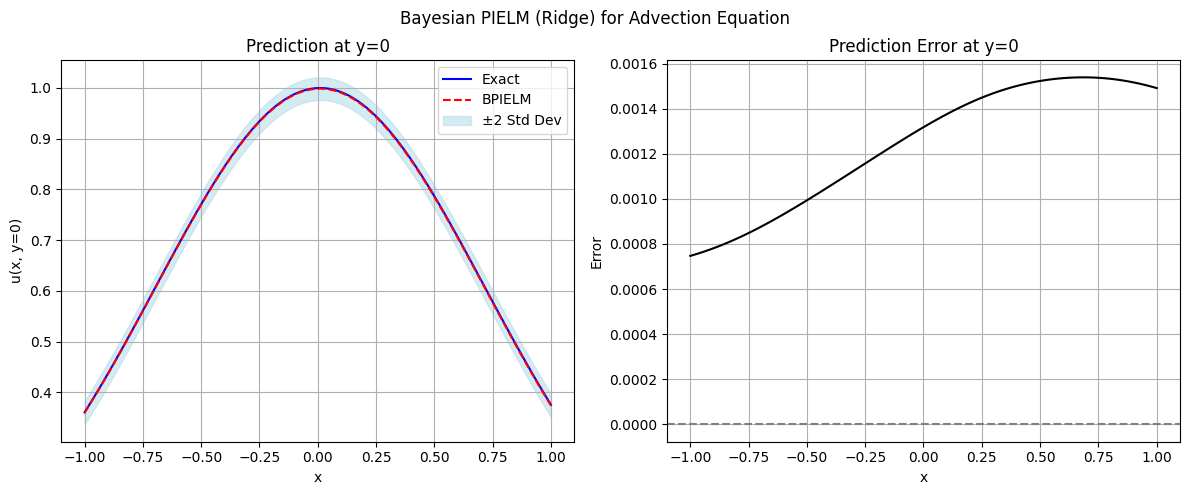

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# -----------------------------
# Activation and Derivatives
# -----------------------------
def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# -----------------------------
# PDE: Advection Equation
# ∂u/∂x + ∂u/∂y = 0
# -----------------------------
def exact_solution(x, y):
    return np.exp(-(x - y)**2)

def rhs_function(x, y):
    return np.zeros_like(x)

# -----------------------------
# Start Timing
# -----------------------------
start_time = time.process_time()

# -----------------------------
# Data: Collocation + Boundary
# -----------------------------
N_col = 400
x_col = np.random.uniform(-1, 1, (N_col, 1))
y_col = np.random.uniform(-1, 1, (N_col, 1))
XY_col = np.hstack([x_col, y_col])

x_b = np.linspace(-1, 1, 10)
y_b = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_b, y_b)

boundary_left   = np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0]))
boundary_right  = np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1]))
boundary_bottom = np.column_stack((xb[0, :], np.full_like(xb[0, :], -1)))
boundary_top    = np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1)))
XY_boundary = np.vstack([boundary_left, boundary_right, boundary_bottom, boundary_top])
N_boundary = XY_boundary.shape[0]

# -----------------------------
# ELM Setup
# -----------------------------
N_neurons = N_col + N_boundary
d = 2
np.random.seed(0)
W = np.random.uniform(-1, 1, (d, N_neurons))
b = np.random.uniform(-1, 1, (1, N_neurons))

# Collocation residual: ∂u/∂x + ∂u/∂y ≈ 0
Z_col = XY_col @ W + b
H_col_x = activation_derivative(Z_col) * W[0, :]
H_col_y = activation_derivative(Z_col) * W[1, :]
H_col = H_col_x + H_col_y
R_col = rhs_function(XY_col[:, 0], XY_col[:, 1]).reshape(-1)

# Boundary: supervise with exact solution
Z_bc = XY_boundary @ W + b
H_bc = activation(Z_bc)
R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1]).reshape(-1)

# Combine all training data
H_total = np.vstack((H_col, H_bc))
K_total = np.concatenate((R_col, R_bc))

# -----------------------------
# Bayesian Ridge Regression
# -----------------------------
gamma = 1e-6   # Prior precision (1 / prior variance of weights)
r2 = 1e-4      # Noise variance (likelihood)

I = np.eye(H_total.shape[1])
HtH = H_total.T @ H_total
HtY = H_total.T @ K_total

# Posterior covariance of weights
R_cov = np.linalg.inv(gamma * I + (1 / r2) * HtH)

# Posterior mean of weights
weights_mean = (1 / r2) * R_cov @ HtY

# -----------------------------
# Prediction on Grid
# -----------------------------
x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])
Z_test = XY_test @ W + b
H_test = activation(Z_test)

# Predictive mean
u_pred = H_test @ weights_mean

# Predictive variance (diagonal approximation)
var_pred = np.sum(H_test @ R_cov * H_test, axis=1) + r2
std_pred = np.sqrt(var_pred).reshape(100, 100)

# Exact solution for comparison
u_exact = exact_solution(XY_test[:, 0], XY_test[:, 1])
error = u_exact - u_pred
U_pred = u_pred.reshape(100, 100)
U_exact = u_exact.reshape(100, 100)
Error_grid = error.reshape(100, 100)

# -----------------------------
# Evaluation
# -----------------------------
mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error ** 2))
Tcpu = time.process_time() - start_time

print(f"MAE      : {mae:.6e}")
print(f"RMSE     : {rmse:.6e}")
print(f"CPU Time : {Tcpu:.6f} seconds")

# -----------------------------
# Visualization: y = 0 slice
# -----------------------------
idx_mid = 50  # y = 0 line
x_plot = x_test
u_pred_plot = U_pred[idx_mid, :]
u_exact_plot = U_exact[idx_mid, :]
std_plot = std_pred[idx_mid, :]
err_plot = Error_grid[idx_mid, :]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_plot, u_exact_plot, 'b-', label='Exact')
plt.plot(x_plot, u_pred_plot, 'r--', label='BPIELM')
plt.fill_between(x_plot, u_pred_plot - 2 * std_plot, u_pred_plot + 2 * std_plot,
                 color='lightblue', alpha=0.5, label='±2 Std Dev')
plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.title('Prediction at y=0')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_plot, err_plot, 'k-', label='Error')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Prediction Error at y=0')
plt.xlabel('x')
plt.ylabel('Error')
plt.grid(True)

plt.tight_layout()
plt.suptitle('Bayesian PIELM (Ridge) for Advection Equation')
plt.subplots_adjust(top=0.88)
plt.show()


Best Neuron count

Best Neuron Count: 125
MAE: 5.284994e-07
RMSE: 9.739365e-07
CPU Time: 38.06 s


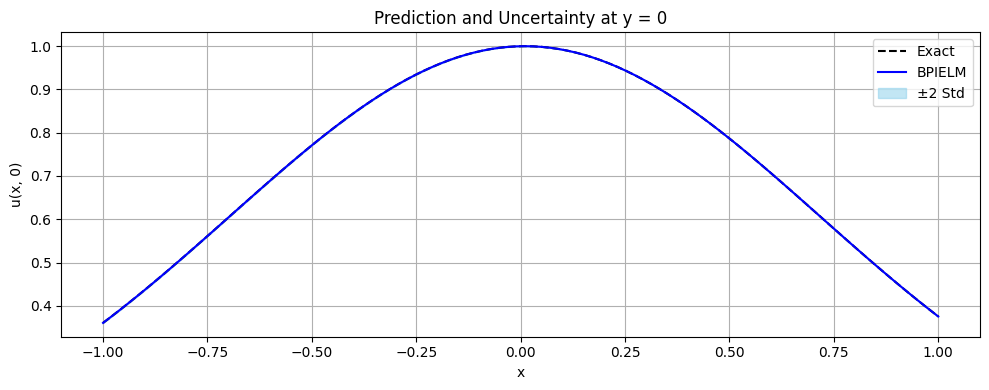

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Activation functions
def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# Exact and RHS for Advection Equation
def exact_solution(x, y):
    return np.exp(-(x - y)**2)

def rhs_function(x, y):
    return np.zeros_like(x)

# Generate data
N_collocation = 400
x_col = np.random.uniform(-1, 1, (N_collocation, 1))
y_col = np.random.uniform(-1, 1, (N_collocation, 1))
XY_col = np.hstack([x_col, y_col])

x_boundary = np.linspace(-1, 1, 10)
y_boundary = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_boundary, y_boundary)
boundary = np.vstack([
    np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0])),
    np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1])),
    np.column_stack((xb[0, :], np.full_like(xb[0, :], -1))),
    np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1))),
])
XY_boundary = boundary

x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])
u_exact_test = exact_solution(XY_test[:, 0], XY_test[:, 1])

# Try different neuron counts
neuron_range = range(50, 1000, 25)
results = []

start_time = time.process_time()
for N_neurons in neuron_range:
    np.random.seed(0)
    W = np.random.uniform(-1, 1, (2, N_neurons))
    b = np.random.uniform(-1, 1, (1, N_neurons))

    Z_col = XY_col @ W + b
    H_col = activation_derivative(Z_col) * W[0, :] + activation_derivative(Z_col) * W[1, :]
    R_col = rhs_function(XY_col[:, 0], XY_col[:, 1])

    Z_bc = XY_boundary @ W + b
    H_bc = activation(Z_bc)
    R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1])

    H_total = np.vstack((H_col, H_bc))
    K_total = np.concatenate((R_col, R_bc))

    C = np.linalg.pinv(H_total) @ K_total

    Z_test = XY_test @ W + b
    H_test = activation(Z_test)
    u_pred = H_test @ C
    error = u_exact_test - u_pred

    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error ** 2))
    results.append((N_neurons, mae, rmse, W, b, C))

# Select best model
best_N, best_mae, best_rmse, best_W, best_b, best_C = min(results, key=lambda x: x[1])

# Final predictions
Z_test = XY_test @ best_W + best_b
H_test = activation(Z_test)
u_best_pred = H_test @ best_C
error = u_exact_test - u_best_pred
sigma2 = np.mean(error ** 2)

# Predictive variance
Z_col_best = XY_col @ best_W + best_b
Z_bc_best = XY_boundary @ best_W + best_b
H_total_best = np.vstack([
    activation_derivative(Z_col_best) * best_W[0, :] + activation_derivative(Z_col_best) * best_W[1, :],
    activation(Z_bc_best)
])
HtH_inv = np.linalg.pinv(H_total_best.T @ H_total_best)
var_pred = np.sum(H_test @ HtH_inv * H_test, axis=1) * sigma2
std_pred = np.sqrt(var_pred).reshape(100, 100)

# Report
print(f"Best Neuron Count: {best_N}")
print(f"MAE: {best_mae:.6e}")
print(f"RMSE: {best_rmse:.6e}")
print(f"CPU Time: {time.process_time() - start_time:.2f} s")

# Visualization
U_pred = u_best_pred.reshape(100, 100)
U_exact = u_exact_test.reshape(100, 100)
mid_idx = 50
plt.figure(figsize=(10, 4))
plt.plot(x_test, U_exact[mid_idx], 'k--', label='Exact')
plt.plot(x_test, U_pred[mid_idx], 'b-', label='BPIELM')
plt.fill_between(x_test,
                 U_pred[mid_idx] - 2 * std_pred[mid_idx],
                 U_pred[mid_idx] + 2 * std_pred[mid_idx],
                 color='skyblue', alpha=0.5, label='±2 Std')
plt.legend()
plt.grid(True)
plt.title("Prediction and Uncertainty at y = 0")
plt.xlabel("x")
plt.ylabel("u(x, 0)")
plt.tight_layout()
plt.show()


Applying ridge regression + Best Neuron count

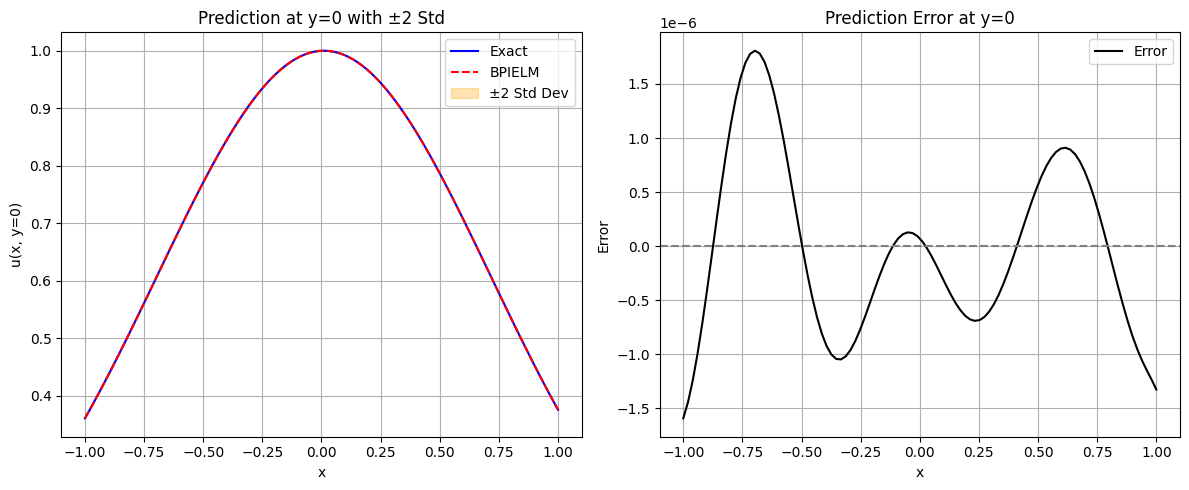

Best Neuron Count: 350
Best Lambda: 1.00e-10
MAE: 7.309398e-07
RMSE: 8.936025e-07
CPU Time: 59.50 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# -----------------------------
# Activation and its derivatives
# -----------------------------

def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# -----------------------------
# Exact Solution and RHS
# -----------------------------

def exact_solution(x, y):
    return np.exp(-(x - y)**2)

def rhs_function(x, y):
    return np.zeros_like(x)

# -----------------------------
# Start Timer
# -----------------------------
start_time = time.process_time()

# -----------------------------
# Collocation and Boundary Points
# -----------------------------

N_collocation = 400
x_col = np.random.uniform(-1, 1, (N_collocation, 1))
y_col = np.random.uniform(-1, 1, (N_collocation, 1))
XY_col = np.hstack([x_col, y_col])

x_boundary = np.linspace(-1, 1, 10)
y_boundary = np.linspace(-1, 1, 10)
xb, yb = np.meshgrid(x_boundary, y_boundary)
boundary_left   = np.column_stack((np.full_like(yb[:, 0], -1), yb[:, 0]))
boundary_right  = np.column_stack((np.full_like(yb[:, -1], 1), yb[:, -1]))
boundary_bottom = np.column_stack((xb[0, :], np.full_like(xb[0, :], -1)))
boundary_top    = np.column_stack((xb[-1, :], np.full_like(xb[-1, :], 1)))
XY_boundary = np.vstack([boundary_left, boundary_right, boundary_bottom, boundary_top])

# -----------------------------
# Test Grid
# -----------------------------

x_test = np.linspace(-1, 1, 100)
y_test = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
XY_test = np.column_stack([X.flatten(), Y.flatten()])
u_exact = exact_solution(XY_test[:, 0], XY_test[:, 1])

# -----------------------------
# Model Setup
# -----------------------------

d = 2
neuron_range = range(50, 500, 25)
lambdas = np.logspace(-10, -1, 10)
results = []

# -----------------------------
# Search for Best Hyperparameters
# -----------------------------

for N_neurons in neuron_range:
    np.random.seed(0)
    W = np.random.uniform(-1, 1, (d, N_neurons))
    b = np.random.uniform(-1, 1, (1, N_neurons))

    Z_col = XY_col @ W + b
    dHdX = activation_derivative(Z_col) * W[0, :]
    dHdY = activation_derivative(Z_col) * W[1, :]
    H_col = dHdX + dHdY
    R_col = rhs_function(XY_col[:, 0], XY_col[:, 1]).reshape(-1)

    Z_bc = XY_boundary @ W + b
    H_bc = activation(Z_bc)
    R_bc = exact_solution(XY_boundary[:, 0], XY_boundary[:, 1]).reshape(-1)

    H_total = np.vstack((H_col, H_bc))
    K_total = np.concatenate((R_col, R_bc))

    for lam in lambdas:
        I = np.eye(H_total.shape[1])
        HtH_lam = H_total.T @ H_total + lam * I
        C_ridge = np.linalg.solve(HtH_lam, H_total.T @ K_total)

        Z_test = XY_test @ W + b
        H_test = activation(Z_test)
        u_pred = H_test @ C_ridge

        mae = np.mean(np.abs(u_exact - u_pred))
        rmse = np.sqrt(np.mean((u_exact - u_pred) ** 2))

        results.append({
            'neurons': N_neurons,
            'lambda': lam,
            'mae': mae,
            'rmse': rmse,
            'C': C_ridge,
            'W': W,
            'b': b,
            'HtH_lam': HtH_lam,
            'H_total': H_total
        })

# -----------------------------
# Best Model Selection
# -----------------------------

best_result = min(results, key=lambda x: x['mae'])
best_C = best_result['C']
W = best_result['W']
b = best_result['b']
HtH_lam = best_result['HtH_lam']
H_total = best_result['H_total']

Z_test = XY_test @ W + b
H_test = activation(Z_test)
u_pred = H_test @ best_C
error = u_exact - u_pred

# Predictive Uncertainty
residuals = H_total @ best_C - np.concatenate((
    rhs_function(XY_col[:, 0], XY_col[:, 1]),
    exact_solution(XY_boundary[:, 0], XY_boundary[:, 1])
))
sigma2 = np.mean(residuals ** 2)
HtH_inv = np.linalg.inv(HtH_lam)
var_pred = sigma2 * np.sum(H_test @ HtH_inv * H_test, axis=1)
std_pred = np.sqrt(var_pred).reshape(100, 100)

# -----------------------------
# y = 0 Slice for Plotting
# -----------------------------

idx_y0 = 50
x_plot = x_test
u_pred_y0 = u_pred.reshape(100, 100)[idx_y0, :]
u_exact_y0 = u_exact.reshape(100, 100)[idx_y0, :]
std_y0 = std_pred[idx_y0, :]
err_y0 = error.reshape(100, 100)[idx_y0, :]

# -----------------------------
# Plot Results
# -----------------------------

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_plot, u_exact_y0, 'b-', label='Exact')
plt.plot(x_plot, u_pred_y0, 'r--', label='BPIELM')
plt.fill_between(x_plot, u_pred_y0 - 2 * std_y0, u_pred_y0 + 2 * std_y0,
                 color='orange', alpha=0.3, label='±2 Std Dev')
plt.xlabel('x')
plt.ylabel('u(x, y=0)')
plt.title('Prediction at y=0 with ±2 Std')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_plot, err_y0, 'k-', label='Error')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Prediction Error at y=0')
plt.xlabel('x')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# -----------------------------
# Summary
# -----------------------------

print(f"Best Neuron Count: {best_result['neurons']}")
print(f"Best Lambda: {best_result['lambda']:.2e}")
print(f"MAE: {best_result['mae']:.6e}")
print(f"RMSE: {best_result['rmse']:.6e}")
print(f"CPU Time: {time.process_time() - start_time:.2f} seconds")


## Diffusion Equation

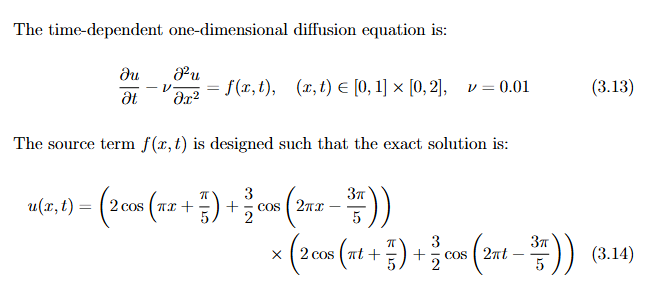

Mean Absolute Error (MAE): 2.356142e-02
Root Mean Square Error (RMSE): 3.493180e-02
CPU Time: 0.228198 seconds


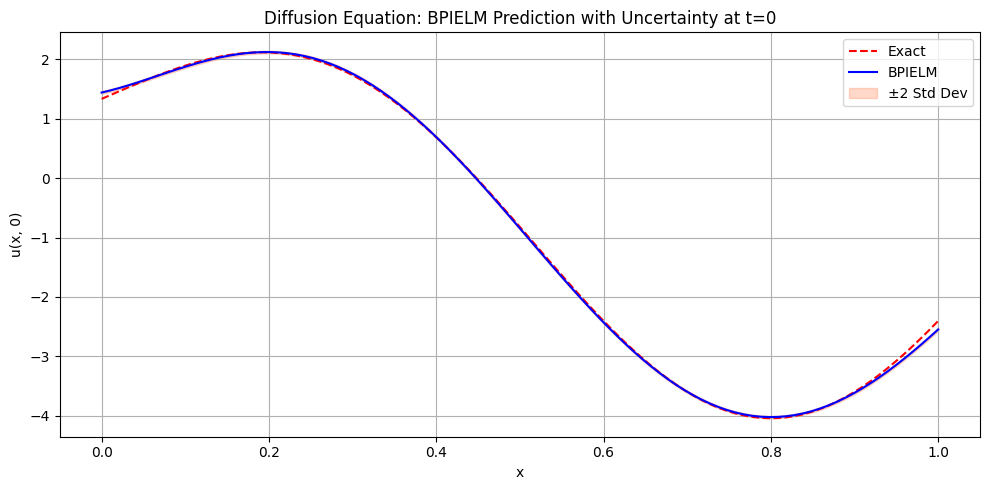

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Activation Functions ---
def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# --- Problem Parameters ---
v = 0.01
pi = np.pi

# Exact solution and source term
def exact_solution(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + (3 / 2) * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + (3 / 2) * np.cos(2 * pi * t - 3 * pi / 5)
    return term1 * term2

def source_term(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + 1.5 * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + 1.5 * np.cos(2 * pi * t - 3 * pi / 5)
    dterm2_dt = -2 * pi * np.sin(pi * t + pi / 5) - 3 * pi * np.sin(2 * pi * t - 3 * pi / 5)
    d2term1_dx2 = -2 * pi**2 * np.cos(pi * x + pi / 5) - 6 * pi**2 * np.cos(2 * pi * x - 3 * pi / 5)
    return term1 * dterm2_dt - v * d2term1_dx2 * term2

# --- Start Timer ---
start_time = time.process_time()

# --- Training Data Generation ---
np.random.seed(0)
Nf = 400
Nb = 28
N_neurons = 180
d = 2

# Collocation points
x_f = np.random.rand(Nf, 1)
t_f = 2 * np.random.rand(Nf, 1)
X_f = np.hstack((x_f, t_f))
f_val = source_term(X_f[:, 0], X_f[:, 1])

# Boundary and initial points
t_b = 2 * np.random.rand(Nb, 1)
X0 = np.hstack((np.zeros_like(t_b), t_b))
X1 = np.hstack((np.ones_like(t_b), t_b))
x_ic = np.random.rand(Nb, 1)
X_ic = np.hstack((x_ic, np.zeros_like(x_ic)))

U0 = exact_solution(X0[:, 0], X0[:, 1]) + np.random.normal(0, 0.01, Nb)
U1 = exact_solution(X1[:, 0], X1[:, 1]) + np.random.normal(0, 0.01, Nb)
U_ic = exact_solution(X_ic[:, 0], X_ic[:, 1]) + np.random.normal(0, 0.01, Nb)

X_b = np.vstack((X0, X1, X_ic))
U_b = np.concatenate((U0, U1, U_ic))

# Hidden layer weights and biases
W = np.random.uniform(-1, 1, (d, N_neurons))
b = np.random.uniform(-1, 1, (1, N_neurons))

# Collocation hidden layer
Z_f = X_f @ W + b
dphi = activation_derivative(Z_f)
phi_t = dphi * W[1, :]
phi_xx = dphi * (W[0, :] ** 2)
H_f = phi_t - v * phi_xx
R_f = f_val

# Boundary hidden layer
Z_b = X_b @ W + b
H_b = activation(Z_b)

# Stack all data
H_total = np.vstack((H_f, H_b))
K_total = np.concatenate((R_f, U_b))

# --- Bayesian Regression Parameters ---
gamma = 1e-6
r2 = 1e-4

I = np.eye(N_neurons)
HtH = H_total.T @ H_total
HtY = H_total.T @ K_total

R_mat = np.linalg.inv(gamma * I + (1 / r2) * HtH)
l = (1 / r2) * R_mat @ HtY

# --- Prediction at t = 0 ---
x_test = np.linspace(0, 1, 100)
t_test = np.zeros_like(x_test)
X_test = np.column_stack([x_test, t_test])

Z_test = X_test @ W + b
H_test = activation(Z_test)

u_pred = H_test @ l
u_exact = exact_solution(X_test[:, 0], X_test[:, 1])

# Predictive variance
var_pred = np.array([
    r2 + (H_test[i, :] @ R_mat @ H_test[i, :].T) for i in range(H_test.shape[0])
])

# --- Error Metrics ---
error = u_exact - u_pred
mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error ** 2))
Tcpu = time.process_time() - start_time

# --- Print Results ---
print(f"Mean Absolute Error (MAE): {mae:.6e}")
print(f"Root Mean Square Error (RMSE): {rmse:.6e}")
print(f"CPU Time: {Tcpu:.6f} seconds")

# --- Plotting ---
std_pred = np.sqrt(var_pred)

plt.figure(figsize=(10, 5))
plt.plot(x_test, u_exact, 'r--', label='Exact')
plt.plot(x_test, u_pred, 'b-', label='BPIELM')
plt.fill_between(x_test, u_pred - 2 * std_pred, u_pred + 2 * std_pred,
                 color='coral', alpha=0.3, label='±2 Std Dev')
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title('Diffusion Equation: BPIELM Prediction with Uncertainty at t=0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


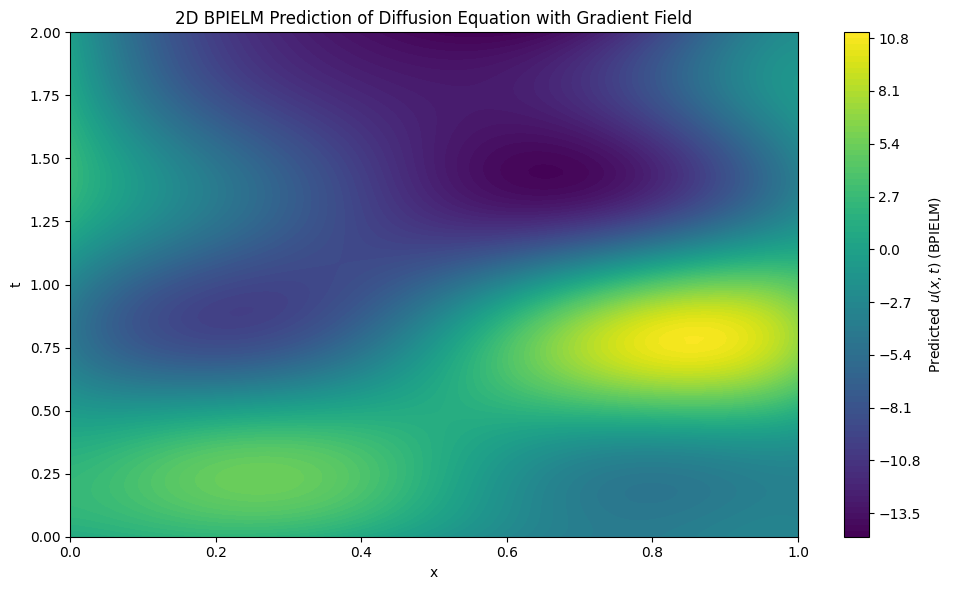

CPU Time: 0.9334 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib import cm

# --- Activation Functions ---
def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# --- Problem Parameters ---
v = 0.01
pi = np.pi

# Exact solution and source term
def exact_solution(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + (3 / 2) * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + (3 / 2) * np.cos(2 * pi * t - 3 * pi / 5)
    return term1 * term2

def source_term(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + 1.5 * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + 1.5 * np.cos(2 * pi * t - 3 * pi / 5)
    dterm2_dt = -2 * pi * np.sin(pi * t + pi / 5) - 3 * pi * np.sin(2 * pi * t - 3 * pi / 5)
    d2term1_dx2 = -2 * pi**2 * np.cos(pi * x + pi / 5) - 6 * pi**2 * np.cos(2 * pi * x - 3 * pi / 5)
    return term1 * dterm2_dt - v * d2term1_dx2 * term2

# --- Start Timer ---
start_time = time.process_time()

# --- Training Data Generation ---
np.random.seed(0)
Nf = 400
Nb = 28
N_neurons = 180
d = 2  # Input dimension: (x, t)

# Collocation points
x_f = np.random.rand(Nf, 1)
t_f = 2 * np.random.rand(Nf, 1)
X_f = np.hstack((x_f, t_f))
f_val = source_term(X_f[:, 0], X_f[:, 1])

# Boundary and initial condition points
t_b = 2 * np.random.rand(Nb, 1)
X0 = np.hstack((np.zeros_like(t_b), t_b))
X1 = np.hstack((np.ones_like(t_b), t_b))
x_ic = np.random.rand(Nb, 1)
X_ic = np.hstack((x_ic, np.zeros_like(x_ic)))

# Noisy boundary values
noise_scale = 0.12
U0 = exact_solution(X0[:, 0], X0[:, 1]) + np.random.normal(0, noise_scale, Nb)
U1 = exact_solution(X1[:, 0], X1[:, 1]) + np.random.normal(0, noise_scale, Nb)
U_ic = exact_solution(X_ic[:, 0], X_ic[:, 1]) + np.random.normal(0, noise_scale, Nb)

X_b = np.vstack((X0, X1, X_ic))
U_b = np.concatenate((U0, U1, U_ic))

# --- Hidden Layer Initialization ---
W = np.random.uniform(-1, 1, (d, N_neurons))
b = np.random.uniform(-1, 1, (1, N_neurons))

# Collocation hidden layer
Z_f = X_f @ W + b
dphi = activation_derivative(Z_f)
phi_t = dphi * W[1, :]
phi_xx = dphi * (W[0, :] ** 2)
H_f = phi_t - v * phi_xx
R_f = f_val

# Boundary hidden layer
Z_b = X_b @ W + b
H_b = activation(Z_b)

# Stack total system
H_total = np.vstack((H_f, H_b))
K_total = np.concatenate((R_f, U_b))

# --- Bayesian Linear Regression ---
gamma = 1e-6
r2 = noise_scale**2
I = np.eye(N_neurons)
HtH = H_total.T @ H_total
HtY = H_total.T @ K_total
R_mat = np.linalg.inv(gamma * I + (1 / r2) * HtH)
l = (1 / r2) * R_mat @ HtY

# --- Prediction Grid ---
x_vis = np.linspace(0, 1, 100)
t_vis = np.linspace(0, 2, 100)
X_grid, T_grid = np.meshgrid(x_vis, t_vis)
X_pred_grid = np.column_stack((X_grid.ravel(), T_grid.ravel()))

Z_pred = X_pred_grid @ W + b
H_pred = activation(Z_pred)
U_pred_flat = H_pred @ l
U_pred = U_pred_flat.reshape(100, 100)

# --- Gradient (numerical) ---
dx = x_vis[1] - x_vis[0]
dt = t_vis[1] - t_vis[0]
dU_dt, dU_dx = np.gradient(U_pred, dt, dx)

# --- 2D Contour Plot with Gradient Arrows ---
plt.figure(figsize=(10, 6))
contour = plt.contourf(X_grid, T_grid, U_pred, levels=100, cmap='viridis')
plt.colorbar(contour, label='Predicted $u(x,t)$ (BPIELM)')


plt.xlabel('x')
plt.ylabel('t')
plt.title('2D BPIELM Prediction of Diffusion Equation with Gradient Field')

plt.tight_layout()
plt.show()

# --- Runtime Info ---
Tcpu = time.process_time() - start_time
print(f"CPU Time: {Tcpu:.4f} seconds")


Applying ridge regression

Best Lambda: 1.00e-10
MAE: 2.371090e-02
RMSE: 3.530149e-02
CPU Time: 0.476903 seconds


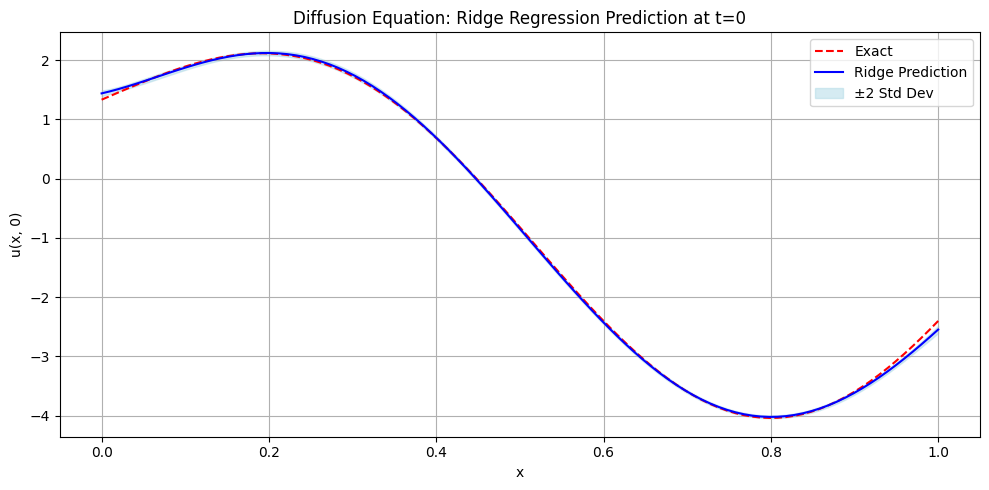

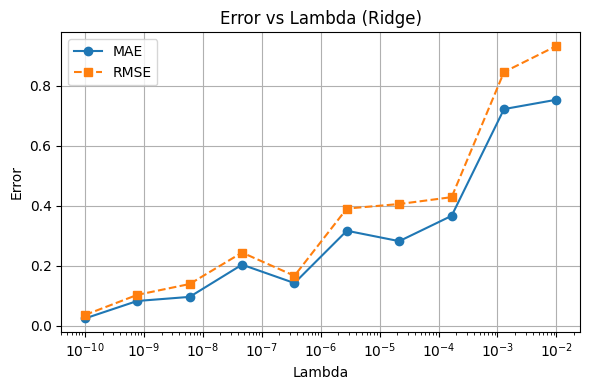

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Activation Functions ---
def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# --- Problem Parameters ---
v = 0.01
pi = np.pi

# --- Exact solution and source term ---
def exact_solution(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + (3 / 2) * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + (3 / 2) * np.cos(2 * pi * t - 3 * pi / 5)
    return term1 * term2

def source_term(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + 1.5 * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + 1.5 * np.cos(2 * pi * t - 3 * pi / 5)
    dterm2_dt = -2 * pi * np.sin(pi * t + pi / 5) - 3 * pi * np.sin(2 * pi * t - 3 * pi / 5)
    d2term1_dx2 = -2 * pi**2 * np.cos(pi * x + pi / 5) - 6 * pi**2 * np.cos(2 * pi * x - 3 * pi / 5)
    return term1 * dterm2_dt - v * d2term1_dx2 * term2

# --- Timer Start ---
start_time = time.process_time()

# --- Data Generation ---
np.random.seed(0)
Nf, Nb, N_neurons, d = 400, 28, 180, 2

# Collocation points
x_f = np.random.rand(Nf, 1)
t_f = 2 * np.random.rand(Nf, 1)
X_f = np.hstack((x_f, t_f))
f_val = source_term(X_f[:, 0], X_f[:, 1])

# Boundary and initial condition points
t_b = 2 * np.random.rand(Nb, 1)
X0 = np.hstack((np.zeros_like(t_b), t_b))
X1 = np.hstack((np.ones_like(t_b), t_b))
x_ic = np.random.rand(Nb, 1)
X_ic = np.hstack((x_ic, np.zeros_like(x_ic)))

U0 = exact_solution(X0[:, 0], X0[:, 1]) + np.random.normal(0, 0.01, Nb)
U1 = exact_solution(X1[:, 0], X1[:, 1]) + np.random.normal(0, 0.01, Nb)
U_ic = exact_solution(X_ic[:, 0], X_ic[:, 1]) + np.random.normal(0, 0.01, Nb)

X_b = np.vstack((X0, X1, X_ic))
U_b = np.concatenate((U0, U1, U_ic))

# Hidden layer weights and biases
W = np.random.uniform(-1, 1, (d, N_neurons))
b = np.random.uniform(-1, 1, (1, N_neurons))

# Collocation hidden layer (∂φ/∂t - v∂²φ/∂x²)
Z_f = X_f @ W + b
dphi = activation_derivative(Z_f)
phi_t = dphi * W[1, :]
phi_xx = dphi * (W[0, :] ** 2)
H_f = phi_t - v * phi_xx
R_f = f_val

# Boundary hidden layer
Z_b = X_b @ W + b
H_b = activation(Z_b)

# Stack everything
H_total = np.vstack((H_f, H_b))
K_total = np.concatenate((R_f, U_b))

# --- Ridge Regression Loop ---
lambdas = np.logspace(-10, -2, 10)
C_list, mae_list, rmse_list = [], [], []

# Test points for t=0
x_test = np.linspace(0, 1, 100)
t_test = np.zeros_like(x_test)
X_test = np.column_stack([x_test, t_test])
Z_test = X_test @ W + b
H_test = activation(Z_test)
u_exact = exact_solution(X_test[:, 0], X_test[:, 1])

for lam in lambdas:
    I = np.eye(H_total.shape[1])
    C_ridge = np.linalg.inv(H_total.T @ H_total + lam * I) @ (H_total.T @ K_total)
    C_list.append(C_ridge)

    u_pred = H_test @ C_ridge
    error = u_exact - u_pred
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error**2))
    mae_list.append(mae)
    rmse_list.append(rmse)

# Best model
best_idx = np.argmin(mae_list)
best_lambda = lambdas[best_idx]
best_C = C_list[best_idx]
u_pred = H_test @ best_C
error = u_exact - u_pred

# --- Predictive variance ---
I = np.eye(H_total.shape[1])
A_inv = np.linalg.inv(H_total.T @ H_total + best_lambda * I)
sigma2 = np.mean(error**2)
var_pred = np.sum(H_test @ A_inv * H_test, axis=1) * sigma2
std_pred = np.sqrt(var_pred)

# --- Error Metrics and Time ---
Tcpu = time.process_time() - start_time

print(f"Best Lambda: {best_lambda:.2e}")
print(f"MAE: {mae_list[best_idx]:.6e}")
print(f"RMSE: {rmse_list[best_idx]:.6e}")
print(f"CPU Time: {Tcpu:.6f} seconds")

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(x_test, u_exact, 'r--', label='Exact')
plt.plot(x_test, u_pred, 'b-', label='Ridge Prediction')
plt.fill_between(x_test, u_pred - 2 * std_pred, u_pred + 2 * std_pred,
                 color='lightblue', alpha=0.5, label='±2 Std Dev')
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title('Diffusion Equation: Ridge Regression Prediction at t=0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Error vs Lambda ---
plt.figure(figsize=(6, 4))
plt.semilogx(lambdas, mae_list, 'o-', label='MAE')
plt.semilogx(lambdas, rmse_list, 's--', label='RMSE')
plt.title('Error vs Lambda (Ridge)')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best Neuron Count

Best Neuron Count: 450
MAE: 7.032718e-03
RMSE: 8.900169e-03
CPU Time: 3.227 s


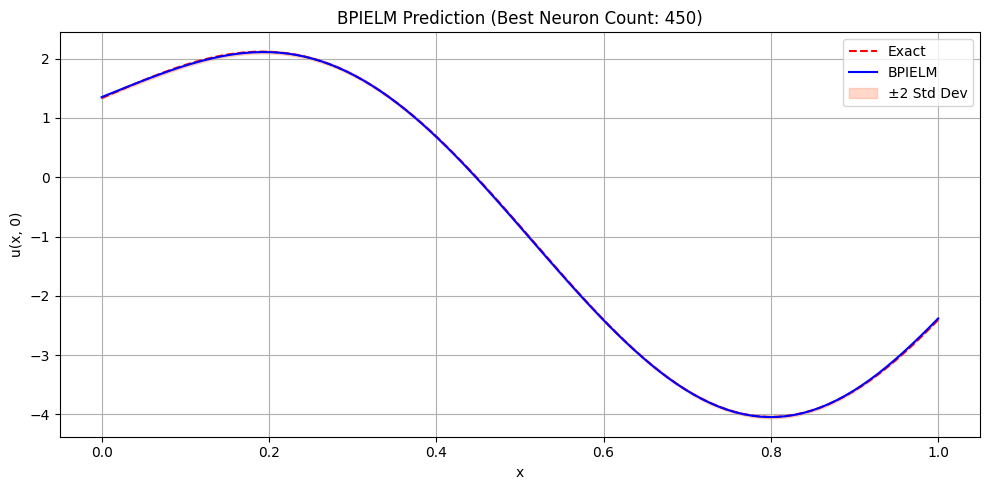

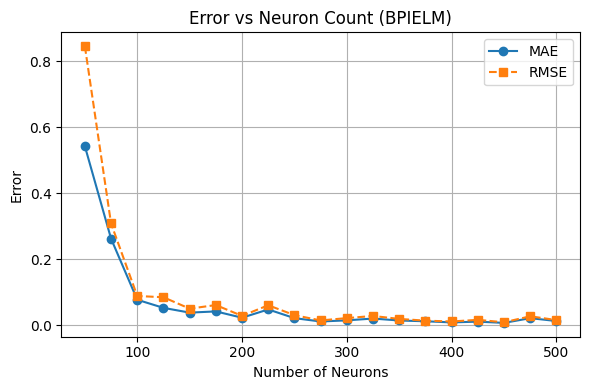

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Activation functions ---
def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# --- Problem constants ---
v = 0.01
pi = np.pi

# --- Exact solution and source term ---
def exact_solution(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + (3 / 2) * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + (3 / 2) * np.cos(2 * pi * t - 3 * pi / 5)
    return term1 * term2

def source_term(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + 1.5 * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + 1.5 * np.cos(2 * pi * t - 3 * pi / 5)
    dterm2_dt = -2 * pi * np.sin(pi * t + pi / 5) - 3 * pi * np.sin(2 * pi * t - 3 * pi / 5)
    d2term1_dx2 = -2 * pi**2 * np.cos(pi * x + pi / 5) - 6 * pi**2 * np.cos(2 * pi * x - 3 * pi / 5)
    return term1 * dterm2_dt - v * d2term1_dx2 * term2

# --- Start timer ---
start_time = time.process_time()

# --- Data preparation ---
np.random.seed(0)
Nf = 400
Nb = 28
d = 2  # input dimension (x, t)

# Collocation points
x_f = np.random.rand(Nf, 1)
t_f = 2 * np.random.rand(Nf, 1)
X_f = np.hstack((x_f, t_f))
f_val = source_term(X_f[:, 0], X_f[:, 1])

# Boundary and initial condition points
t_b = 2 * np.random.rand(Nb, 1)
X0 = np.hstack((np.zeros_like(t_b), t_b))
X1 = np.hstack((np.ones_like(t_b), t_b))
x_ic = np.random.rand(Nb, 1)
X_ic = np.hstack((x_ic, np.zeros_like(x_ic)))

U0 = exact_solution(X0[:, 0], X0[:, 1]) + np.random.normal(0, 0.01, Nb)
U1 = exact_solution(X1[:, 0], X1[:, 1]) + np.random.normal(0, 0.01, Nb)
U_ic = exact_solution(X_ic[:, 0], X_ic[:, 1]) + np.random.normal(0, 0.01, Nb)

X_b = np.vstack((X0, X1, X_ic))
U_b = np.concatenate((U0, U1, U_ic))

# --- Range of neuron counts ---
neuron_range = range(50, 501, 25)
mae_list, rmse_list = [], []
models = []

# --- Loop over neuron counts ---
for N_neurons in neuron_range:
    # Random weights and biases
    W = np.random.uniform(-1, 1, (d, N_neurons))
    b = np.random.uniform(-1, 1, (1, N_neurons))

    # Hidden layer for PDE residuals
    Z_f = X_f @ W + b
    dphi = activation_derivative(Z_f)
    phi_t = dphi * W[1, :]
    phi_xx = dphi * (W[0, :] ** 2)
    H_f = phi_t - v * phi_xx
    R_f = f_val

    # Hidden layer for boundary + initial condition
    Z_b = X_b @ W + b
    H_b = activation(Z_b)

    # Combine physics and data
    H_total = np.vstack((H_f, H_b))
    K_total = np.concatenate((R_f, U_b))

    # --- Bayesian regression ---
    gamma = 1e-6
    r2 = 1e-4
    I = np.eye(N_neurons)

    HtH = H_total.T @ H_total
    HtY = H_total.T @ K_total
    R_mat = np.linalg.inv(gamma * I + (1 / r2) * HtH)
    l = (1 / r2) * R_mat @ HtY

    # Prediction at t = 0
    x_test = np.linspace(0, 1, 100)
    t_test = np.zeros_like(x_test)
    X_test = np.column_stack([x_test, t_test])

    Z_test = X_test @ W + b
    H_test = activation(Z_test)
    u_pred = H_test @ l
    u_exact = exact_solution(X_test[:, 0], X_test[:, 1])

    # Predictive variance
    var_pred = np.array([
        r2 + (H_test[i, :] @ R_mat @ H_test[i, :].T) for i in range(H_test.shape[0])
    ])
    std_pred = np.sqrt(var_pred)

    # Errors
    error = u_exact - u_pred
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error ** 2))

    mae_list.append(mae)
    rmse_list.append(rmse)
    models.append((W, b, l, std_pred, u_pred))

# --- Select best model ---
best_index = np.argmin(mae_list)
best_N = list(neuron_range)[best_index]
best_W, best_b, best_l, best_std, best_pred = models[best_index]

# --- Final prediction and plotting ---
u_exact = exact_solution(x_test, t_test)
error = u_exact - best_pred

Tcpu = time.process_time() - start_time

# --- Reporting ---
print(f"Best Neuron Count: {best_N}")
print(f"MAE: {mae_list[best_index]:.6e}")
print(f"RMSE: {rmse_list[best_index]:.6e}")
print(f"CPU Time: {Tcpu:.3f} s")

# --- Plot prediction and uncertainty ---
plt.figure(figsize=(10, 5))
plt.plot(x_test, u_exact, 'r--', label='Exact')
plt.plot(x_test, best_pred, 'b-', label='BPIELM')
plt.fill_between(x_test,
                 best_pred - 2 * best_std,
                 best_pred + 2 * best_std,
                 color='coral', alpha=0.3, label='±2 Std Dev')
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title(f'BPIELM Prediction (Best Neuron Count: {best_N})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot error vs neuron count ---
plt.figure(figsize=(6, 4))
plt.plot(list(neuron_range), mae_list, 'o-', label='MAE')
plt.plot(list(neuron_range), rmse_list, 's--', label='RMSE')
plt.xlabel('Number of Neurons')
plt.ylabel('Error')
plt.title('Error vs Neuron Count (BPIELM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Applying ridge regression + Best Neuron count

Best Neuron Count: 950
Best Lambda: 1.00e-10
MAE: 5.288599e-03
RMSE: 7.198373e-03
CPU Time: 21.475872 seconds


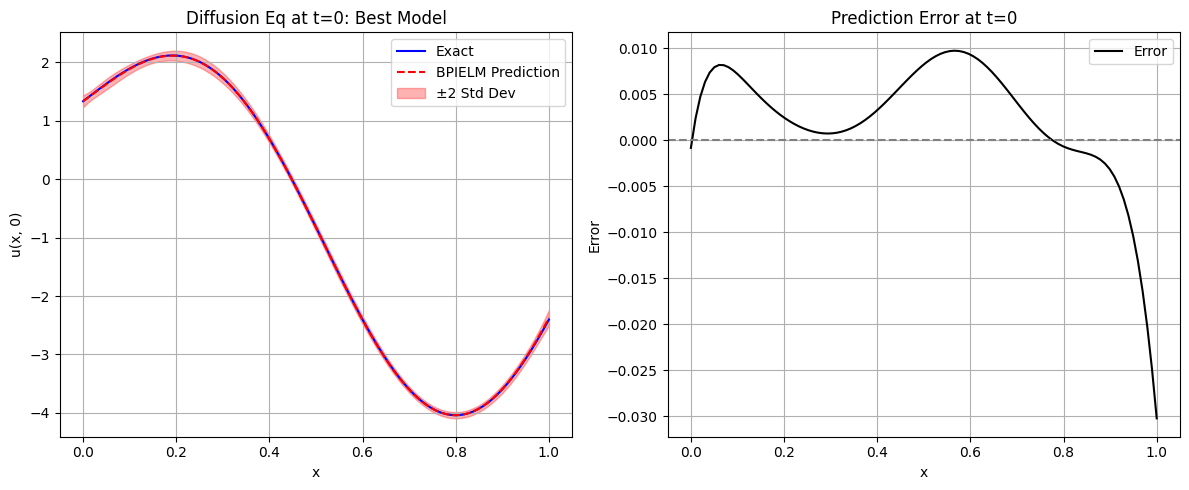

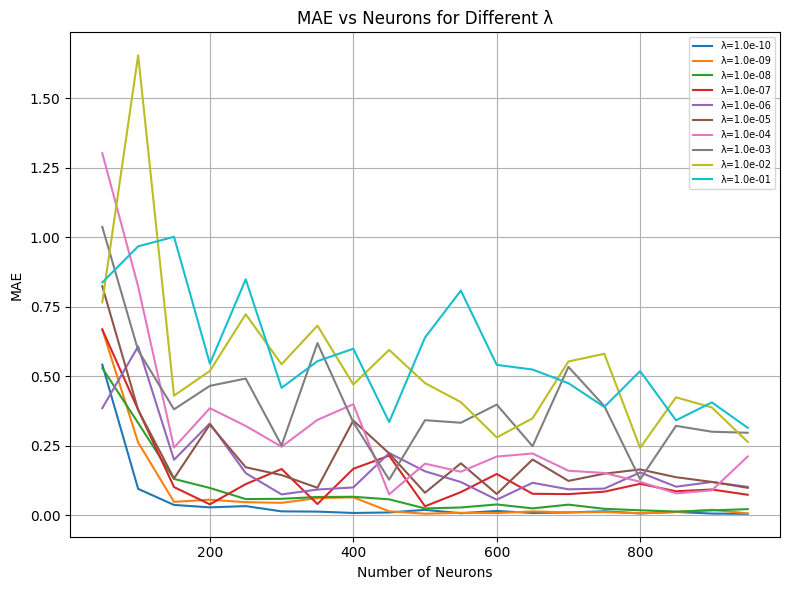

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

# --- Activation Functions ---
def activation(z):
    return np.tanh(z)

def activation_derivative(z):
    return 1 - np.tanh(z) ** 2

# --- Problem Parameters ---
v = 0.01
pi = np.pi

# --- Exact solution and source term ---
def exact_solution(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + (3 / 2) * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + (3 / 2) * np.cos(2 * pi * t - 3 * pi / 5)
    return term1 * term2

def source_term(x, t):
    term1 = 2 * np.cos(pi * x + pi / 5) + 1.5 * np.cos(2 * pi * x - 3 * pi / 5)
    term2 = 2 * np.cos(pi * t + pi / 5) + 1.5 * np.cos(2 * pi * t - 3 * pi / 5)
    dterm2_dt = -2 * pi * np.sin(pi * t + pi / 5) - 3 * pi * np.sin(2 * pi * t - 3 * pi / 5)
    d2term1_dx2 = -2 * pi**2 * np.cos(pi * x + pi / 5) - 6 * pi**2 * np.cos(2 * pi * x - 3 * pi / 5)
    return term1 * dterm2_dt - v * d2term1_dx2 * term2

# --- Start Timer ---
start_time = time.process_time()

# --- Training Data Generation ---
np.random.seed(0)
Nf = 400
Nb = 28
d = 2
neuron_range = range(50, 1000, 50)
lambdas = np.logspace(-10, -1, 10)
results = []

x_f = np.random.rand(Nf, 1)
t_f = 2 * np.random.rand(Nf, 1)
X_f = np.hstack((x_f, t_f))
f_val = source_term(X_f[:, 0], X_f[:, 1])

t_b = 2 * np.random.rand(Nb, 1)
X0 = np.hstack((np.zeros_like(t_b), t_b))
X1 = np.hstack((np.ones_like(t_b), t_b))
x_ic = np.random.rand(Nb, 1)
X_ic = np.hstack((x_ic, np.zeros_like(x_ic)))
X_b = np.vstack((X0, X1, X_ic))

U0 = exact_solution(X0[:, 0], X0[:, 1]) + np.random.normal(0, 0.01, Nb)
U1 = exact_solution(X1[:, 0], X1[:, 1]) + np.random.normal(0, 0.01, Nb)
U_ic = exact_solution(X_ic[:, 0], X_ic[:, 1]) + np.random.normal(0, 0.01, Nb)
U_b = np.concatenate((U0, U1, U_ic))

# --- Grid for Testing at t = 0 ---
x_test = np.linspace(0, 1, 100)
t_test = np.zeros_like(x_test)
X_test = np.column_stack([x_test, t_test])
u_exact = exact_solution(X_test[:, 0], X_test[:, 1])

# --- Loop over neurons and lambda ---
for N_neurons in neuron_range:
    W = np.random.uniform(-1, 1, (d, N_neurons))
    b = np.random.uniform(-1, 1, (1, N_neurons))

    Z_f = X_f @ W + b
    dphi = activation_derivative(Z_f)
    phi_t = dphi * W[1, :]
    phi_xx = dphi * (W[0, :] ** 2)
    H_f = phi_t - v * phi_xx
    R_f = f_val

    Z_b = X_b @ W + b
    H_b = activation(Z_b)

    H_total = np.vstack((H_f, H_b))
    K_total = np.concatenate((R_f, U_b))

    for lam in lambdas:
        I = np.eye(N_neurons)
        HtH_lam = H_total.T @ H_total + lam * I
        HtY = H_total.T @ K_total
        coef = np.linalg.solve(HtH_lam, HtY)

        Z_test = X_test @ W + b
        H_test = activation(Z_test)
        u_pred = H_test @ coef
        mae = np.mean(np.abs(u_exact - u_pred))
        rmse = np.sqrt(np.mean((u_exact - u_pred) ** 2))

        results.append({
            'neurons': N_neurons,
            'lambda': lam,
            'mae': mae,
            'rmse': rmse,
            'coef': coef,
            'W': W,
            'b': b,
            'HtH_lam': HtH_lam,
            'H_total': H_total
        })

# --- Best model selection ---
best_result = min(results, key=lambda x: x['mae'])
W = best_result['W']
b = best_result['b']
coef = best_result['coef']
HtH_lam = best_result['HtH_lam']
H_total = best_result['H_total']
best_N = best_result['neurons']
best_lambda = best_result['lambda']

Z_test = X_test @ W + b
H_test = activation(Z_test)
u_pred = H_test @ coef
error = u_exact - u_pred

# Estimate predictive variance
residuals = H_total @ coef - np.concatenate((f_val, U_b))
sigma2 = np.mean(residuals ** 2)
HtH_inv = np.linalg.inv(HtH_lam)
var_pred = sigma2 * np.sum(H_test @ HtH_inv * H_test, axis=1)
std_pred = np.sqrt(var_pred)

# --- Error Metrics ---
mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error ** 2))
Tcpu = time.process_time() - start_time

# --- Output ---
print(f"Best Neuron Count: {best_N}")
print(f"Best Lambda: {best_lambda:.2e}")
print(f"MAE: {mae:.6e}")
print(f"RMSE: {rmse:.6e}")
print(f"CPU Time: {Tcpu:.6f} seconds")

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_test, u_exact, 'b-', label='Exact')
plt.plot(x_test, u_pred, 'r--', label='BPIELM Prediction')
plt.fill_between(x_test, u_pred - 2 * std_pred, u_pred + 2 * std_pred,
                 color='red', alpha=0.3, label='±2 Std Dev')
plt.title('Diffusion Eq at t=0: Best Model')
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x_test, error, 'k-', label='Error')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Prediction Error at t=0')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- MAE vs Neuron Plot ---
df = pd.DataFrame(results)
plt.figure(figsize=(8, 6))
for lam in lambdas:
    subset = df[df['lambda'] == lam]
    plt.plot(subset['neurons'], subset['mae'], label=f'λ={lam:.1e}')
plt.xlabel('Number of Neurons')
plt.ylabel('MAE')
plt.title('MAE vs Neurons for Different λ')
plt.legend(fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.show()
